# Experiment - Toy Simulations

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])
pysim_root = "/home/emmanuel/code/pysim"
# append to path
sys.path.append(str(root))
sys.path.append(str(pysim_root))

import numpy as np

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Mutual Information

In [2]:
# ==========================
# INITIALIZE LOGGER
# ==========================
import wandb

wandb_logger = wandb.init(project="sim4clim_toysim", entity="ipl_uv")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml4floods (use `wandb login --relogin` to force relogin)


## Dataset

### Beyond Correlation

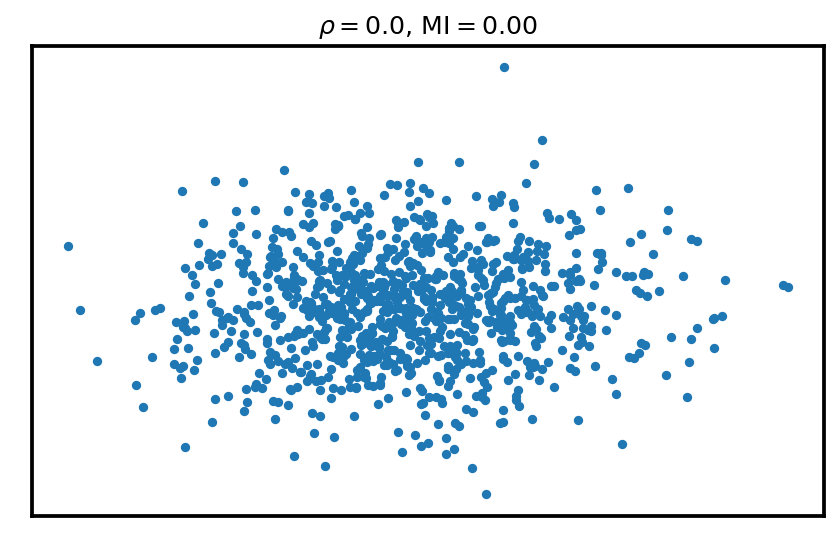

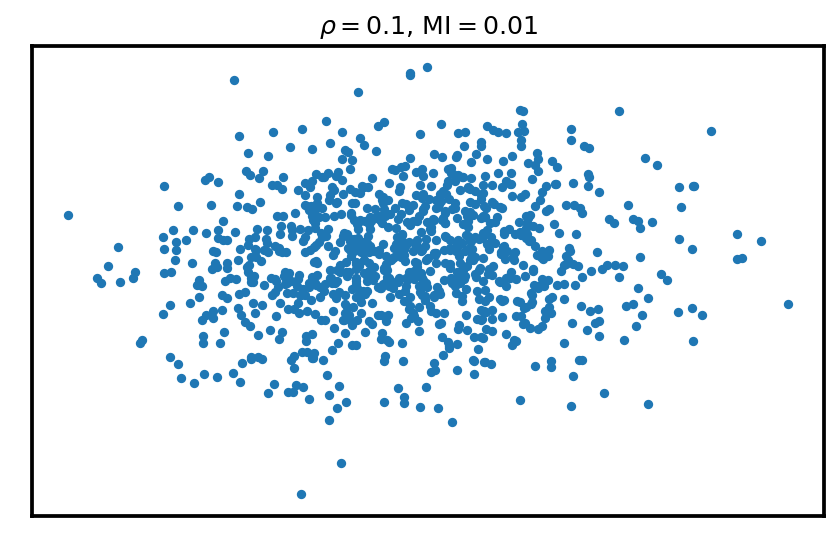

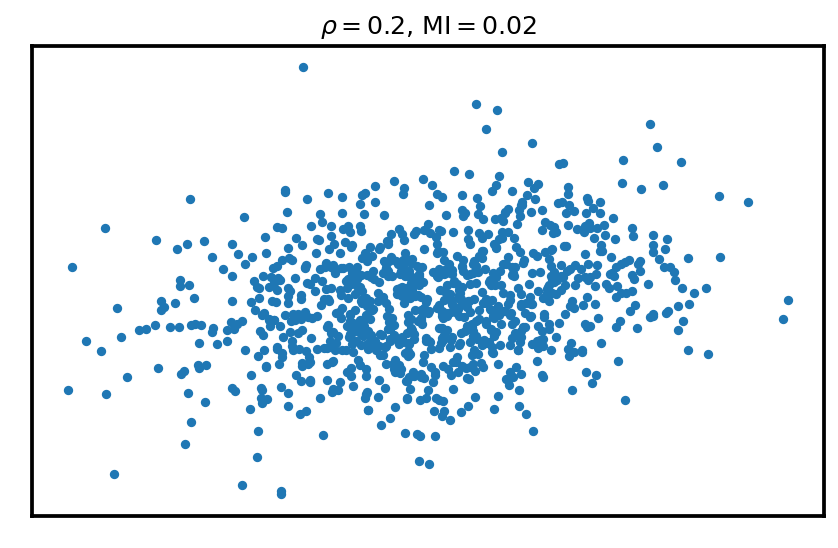

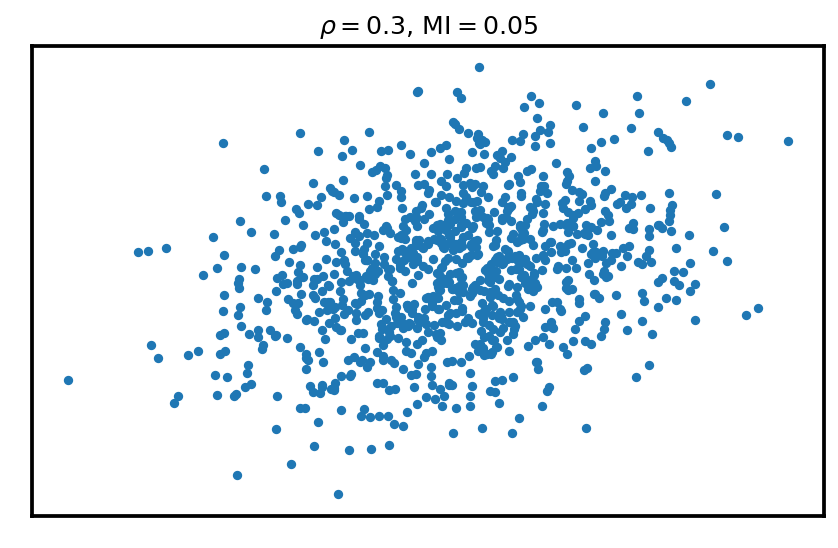

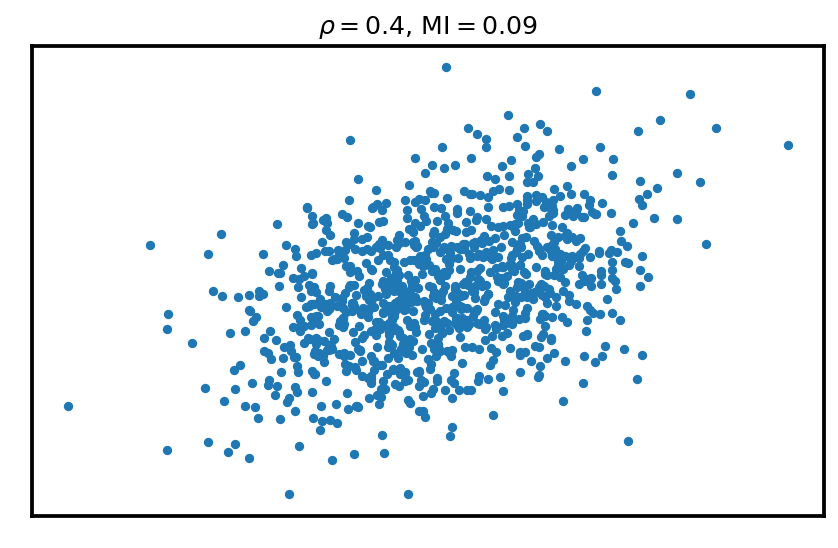

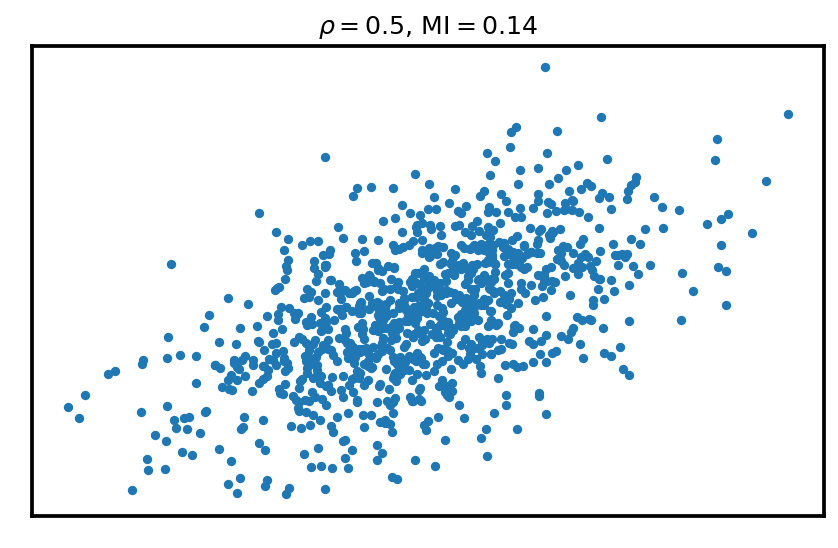

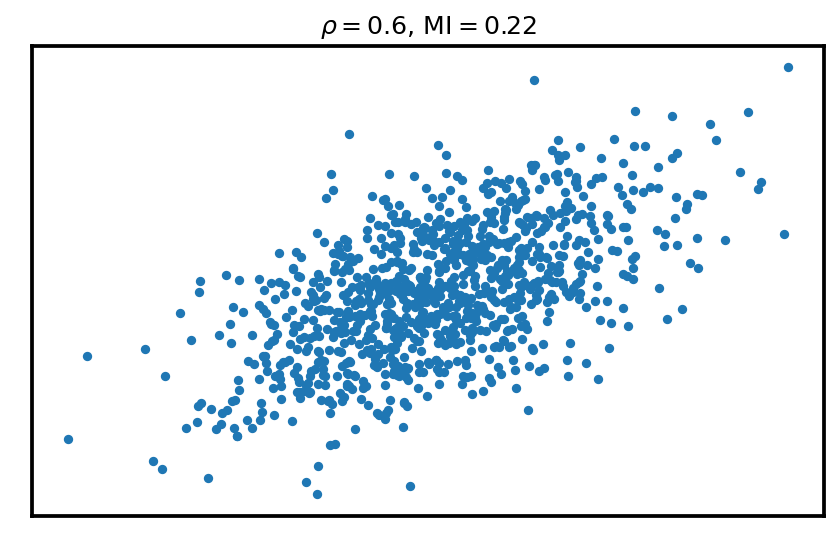

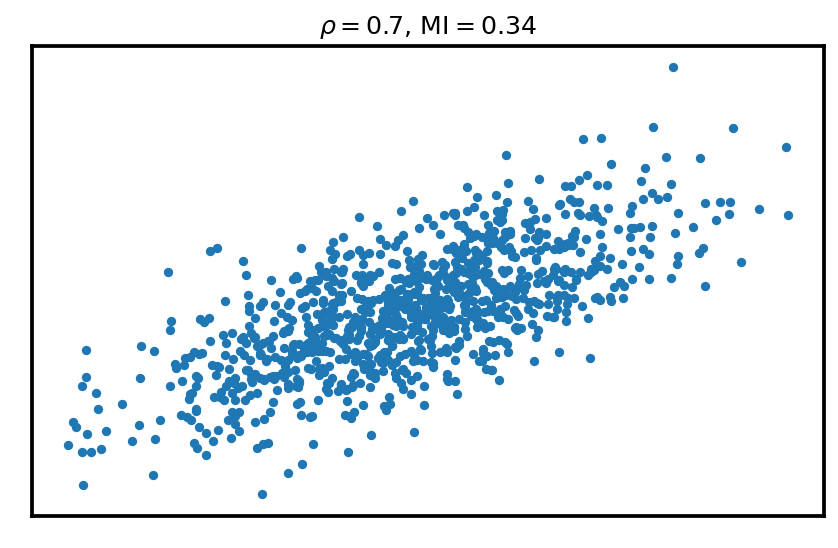

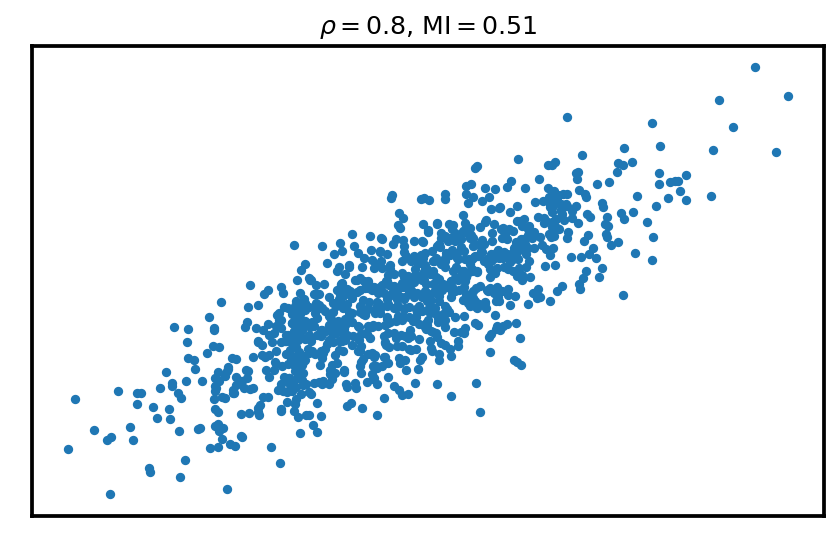

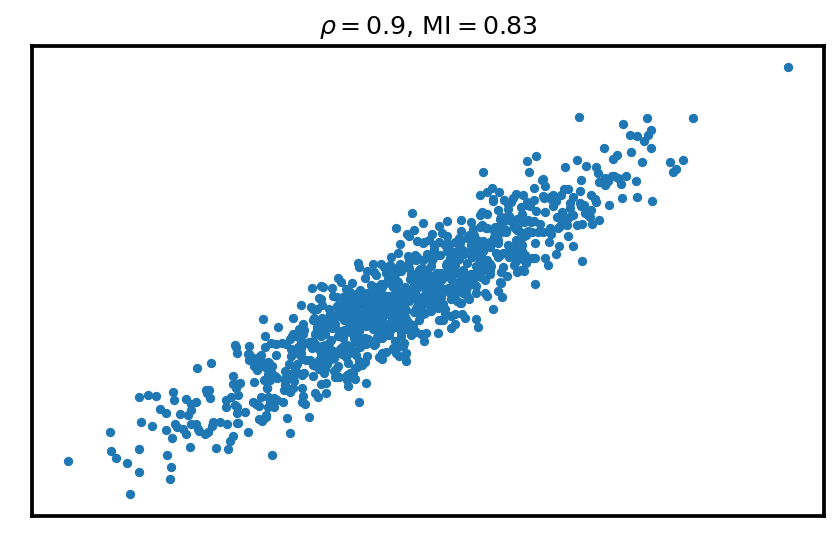

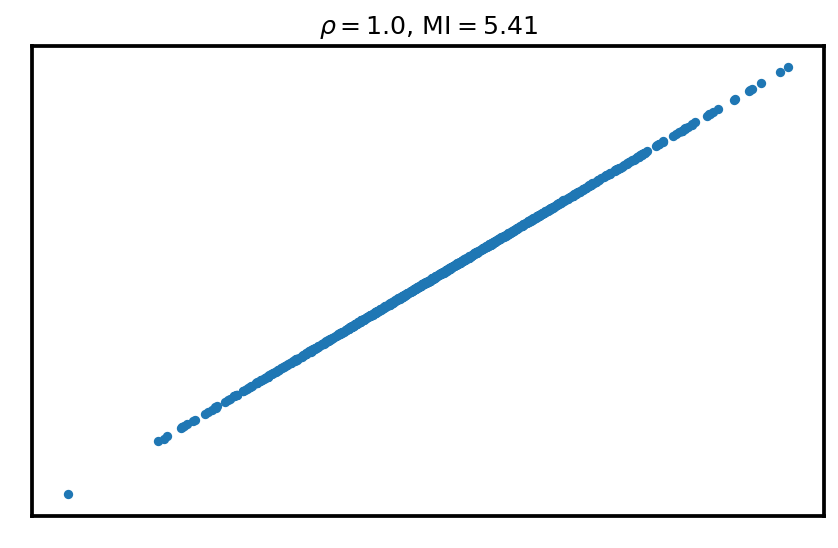

In [4]:
mus = [0.000001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99999]

for i in mus:
    x = np.random.multivariate_normal(mean=[0, 0], cov=[[1, i], [i, 1]], size=1_000)

    mi = -0.5 * np.log(1 - i ** 2)

    fig, ax = plt.subplots()
    ax.scatter(x[:, 0], x[:, 1], s=10)
    ax.set(xticks=[], yticks=[], title=rf"$\rho={i:.1f}$, MI$={mi:.2f}$")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

### With Noise

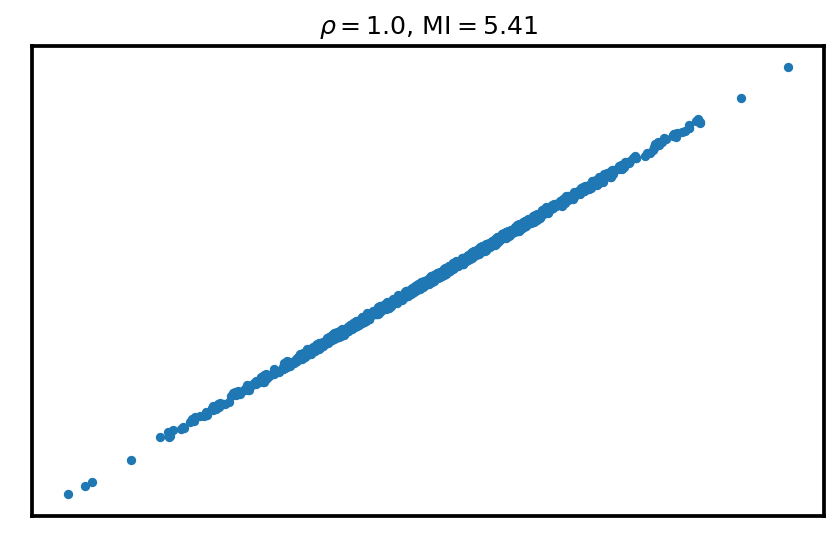

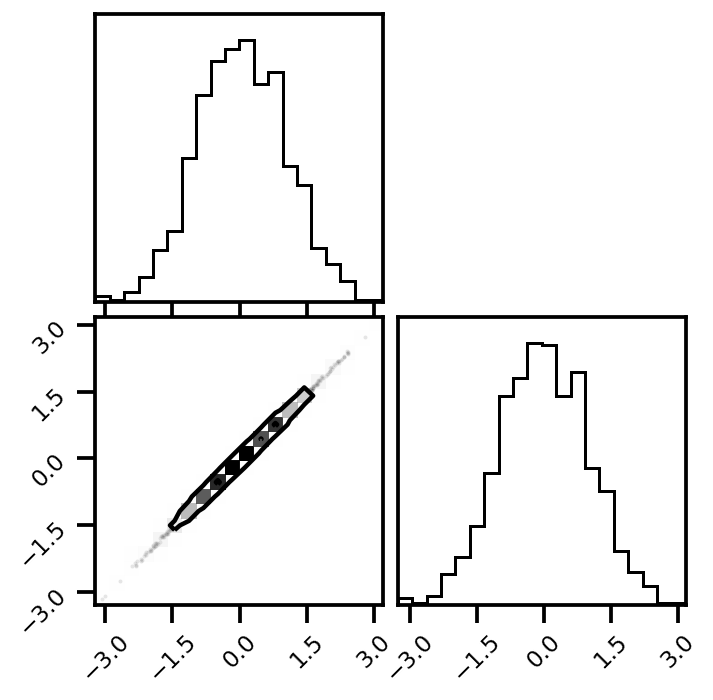

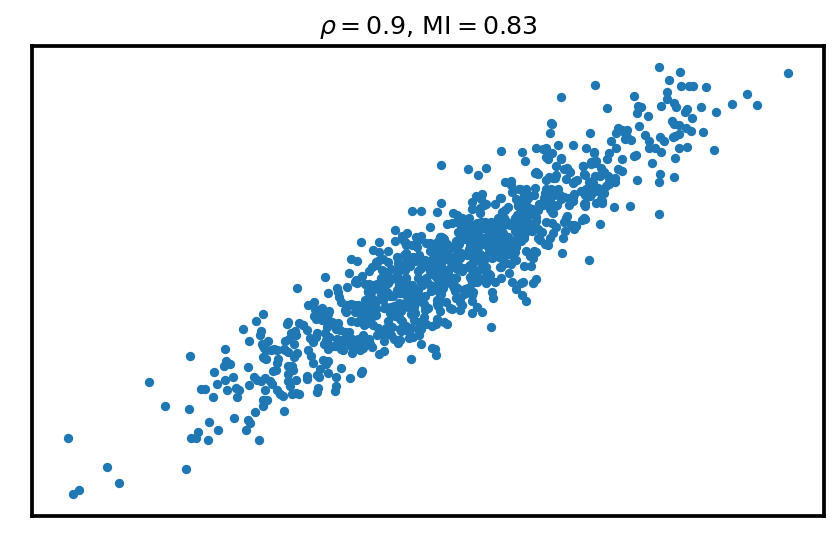

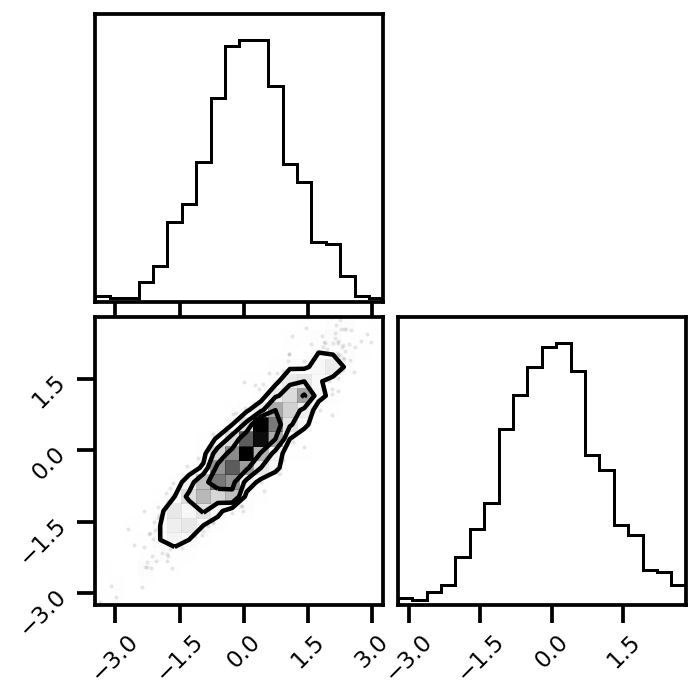

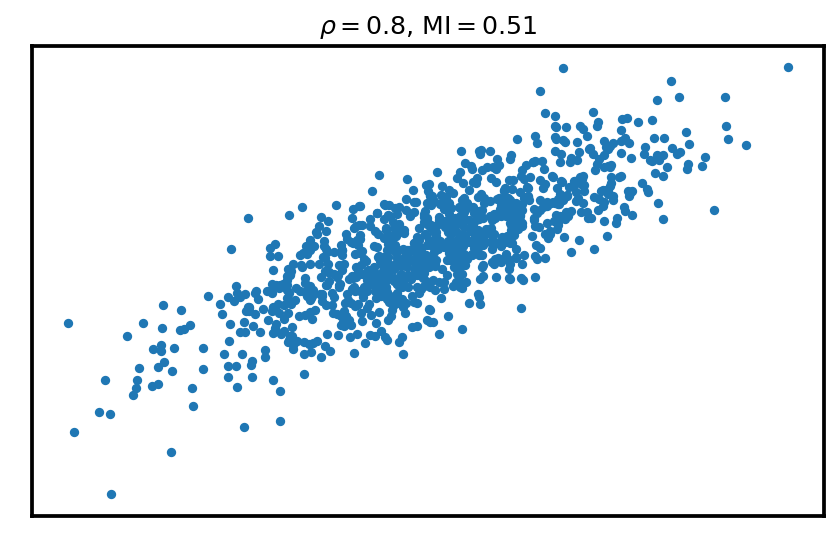

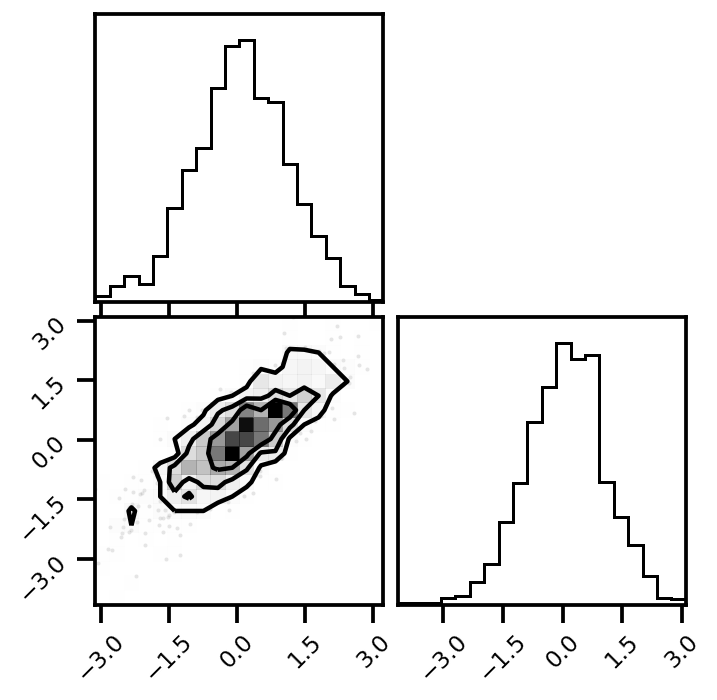

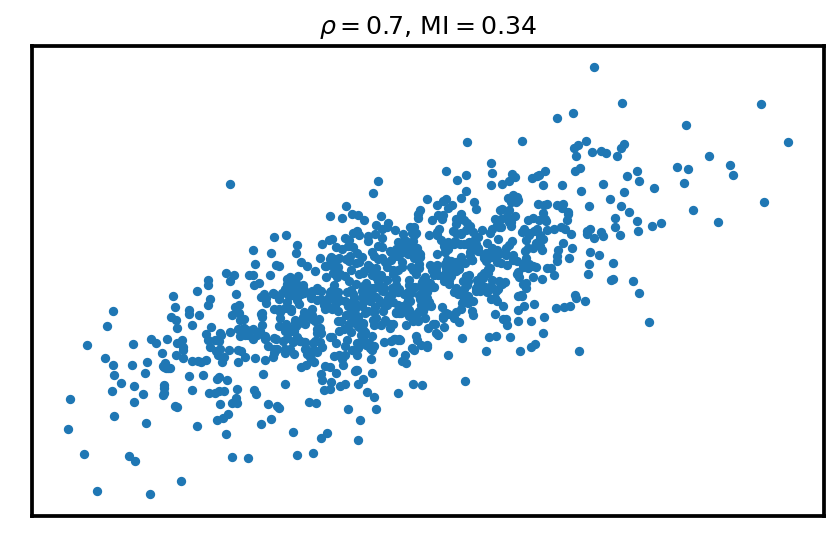

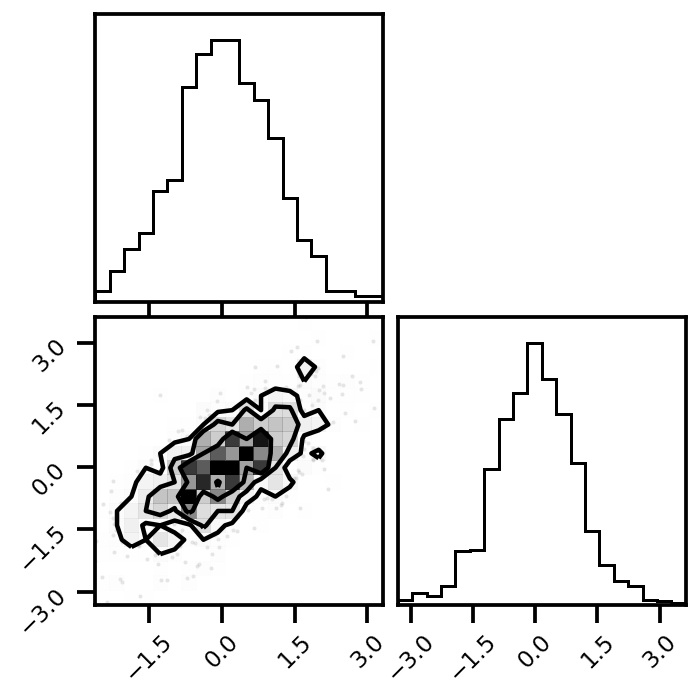

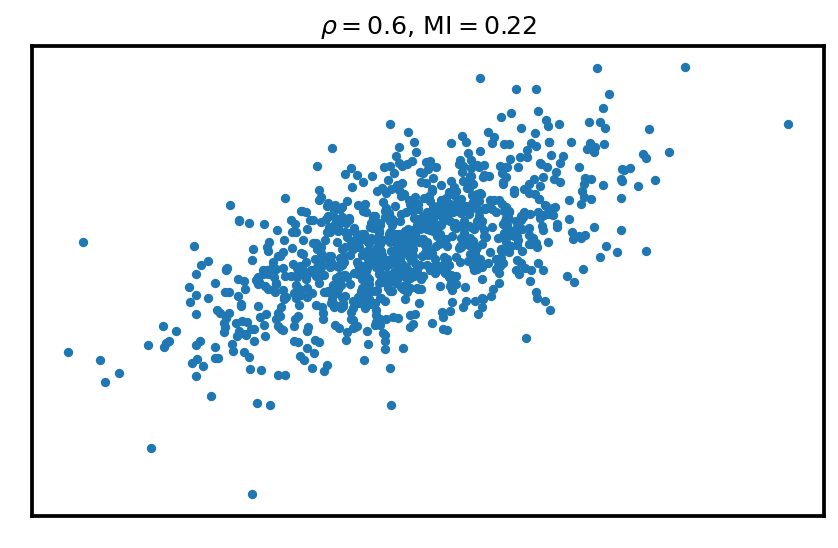

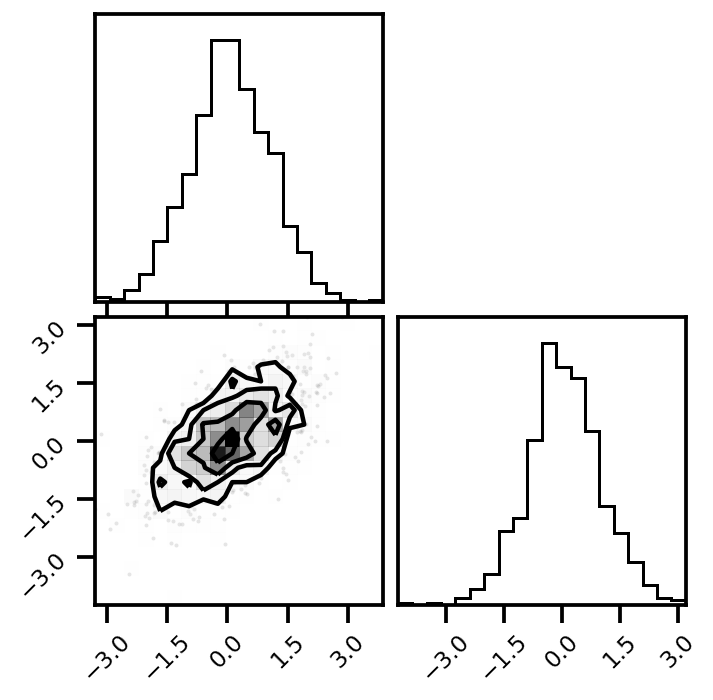

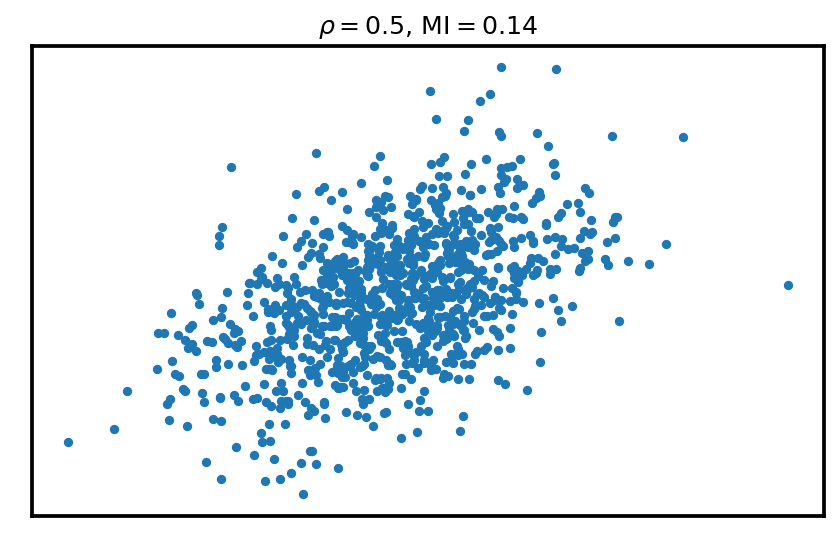

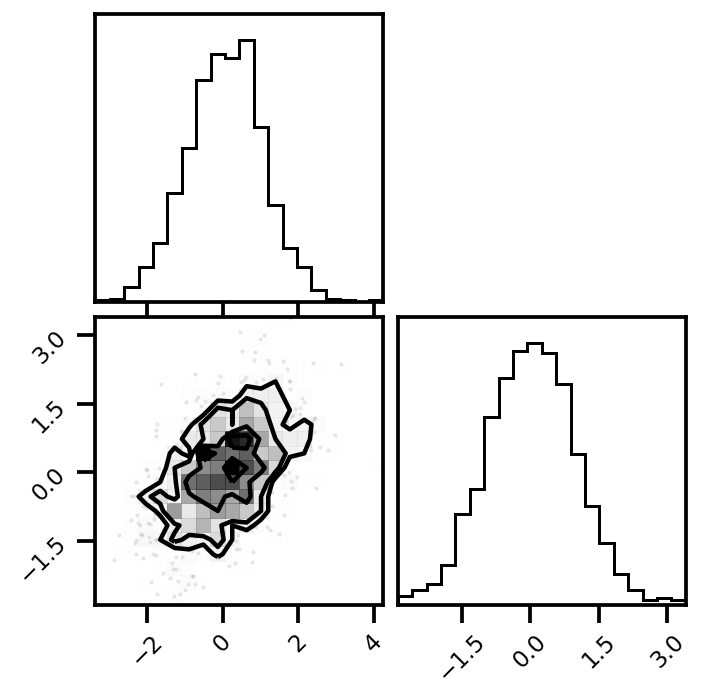

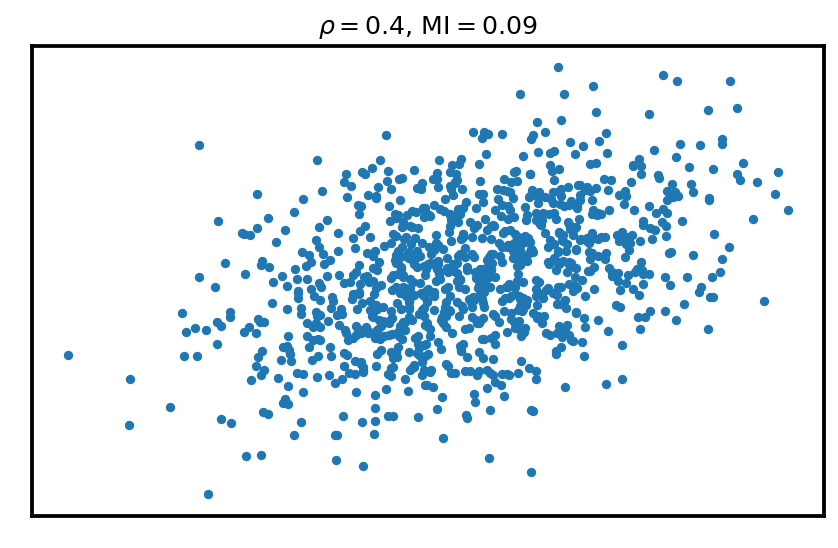

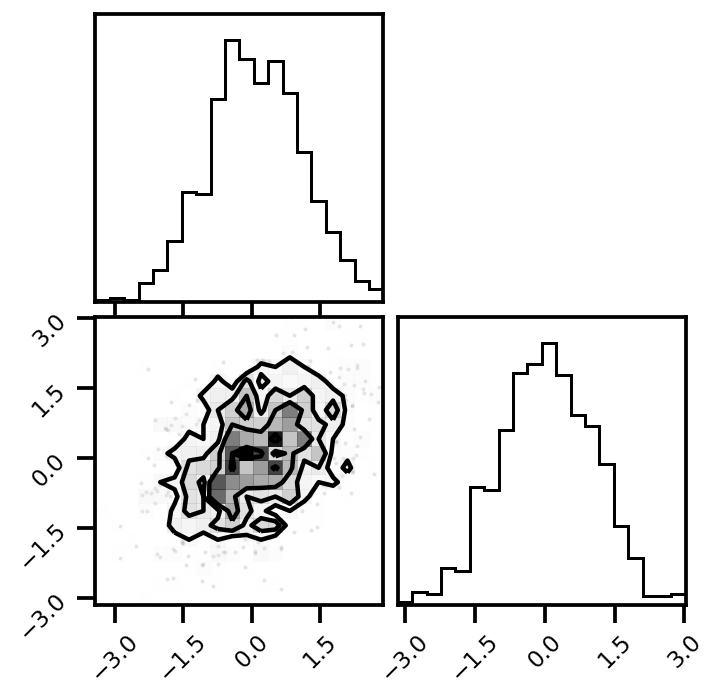

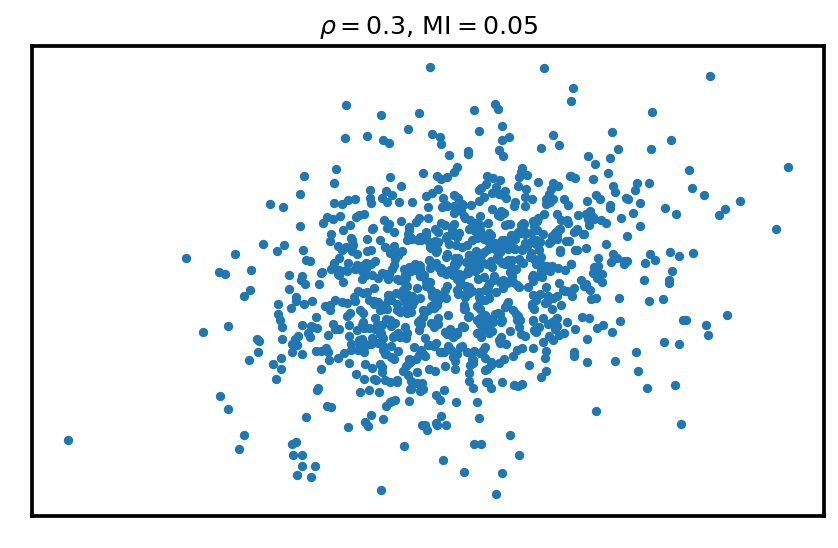

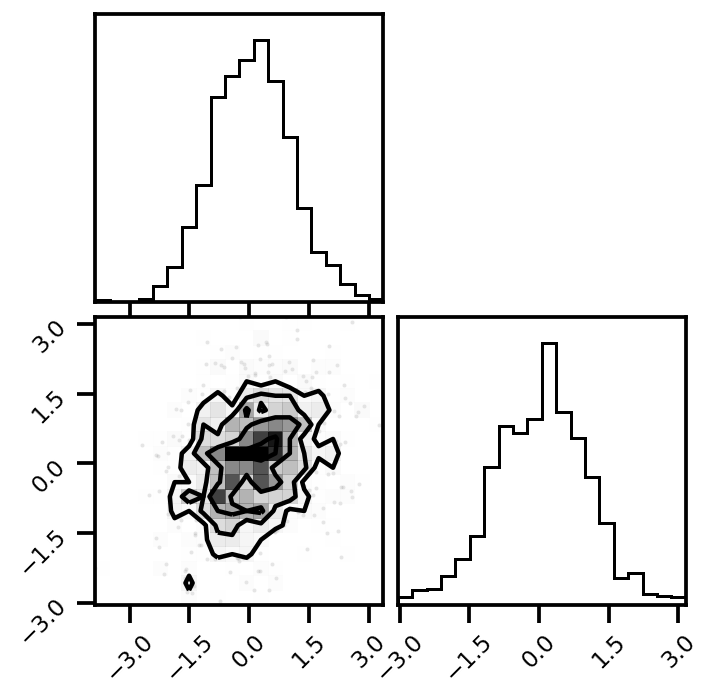

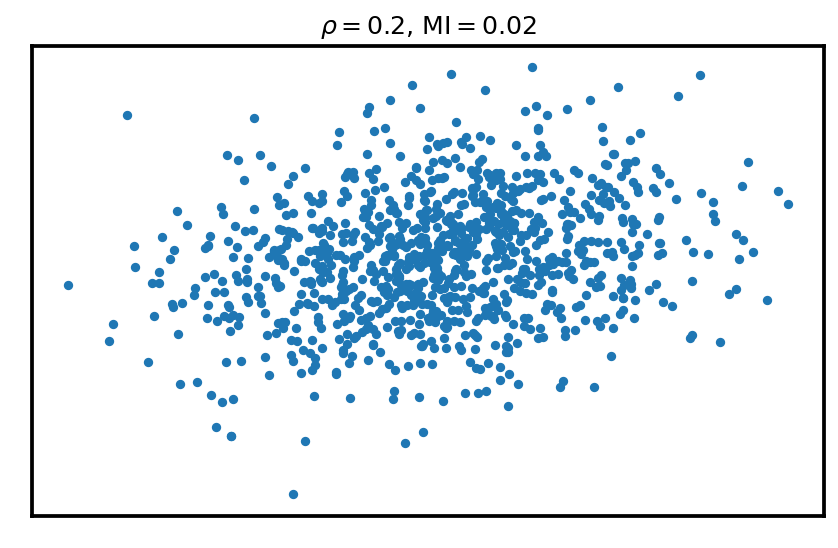

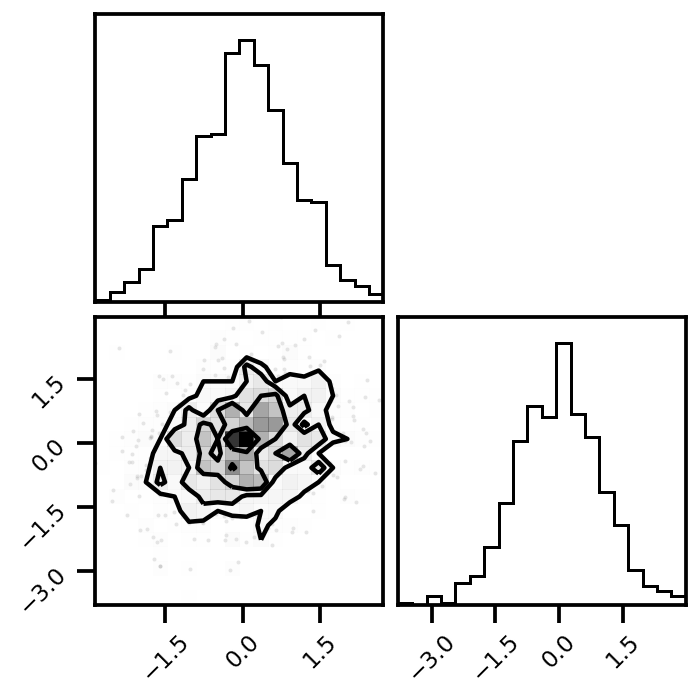

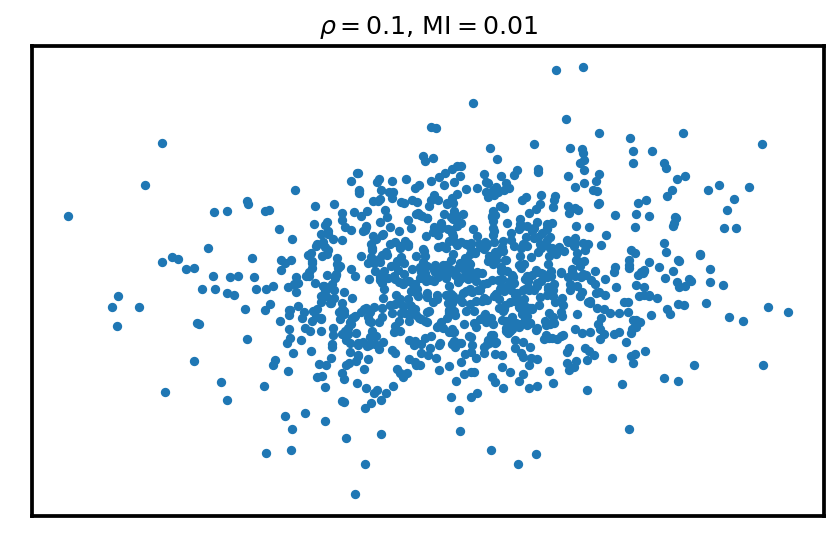

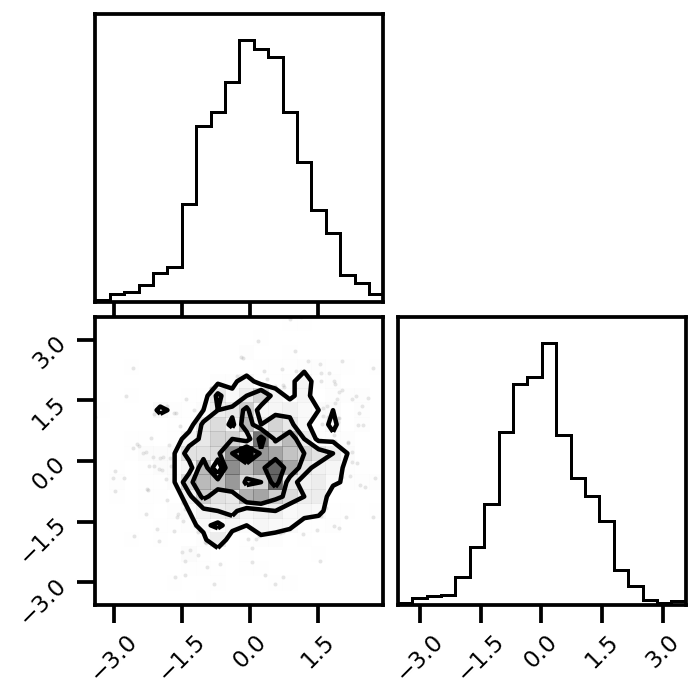

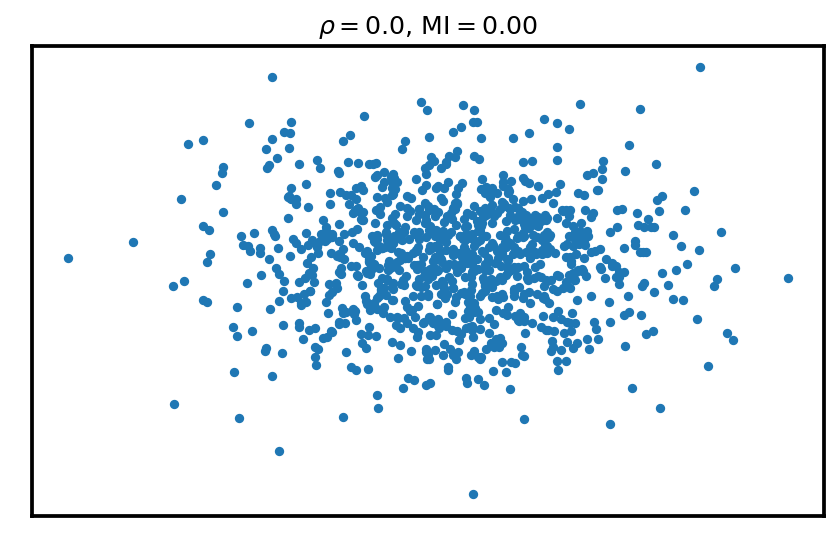

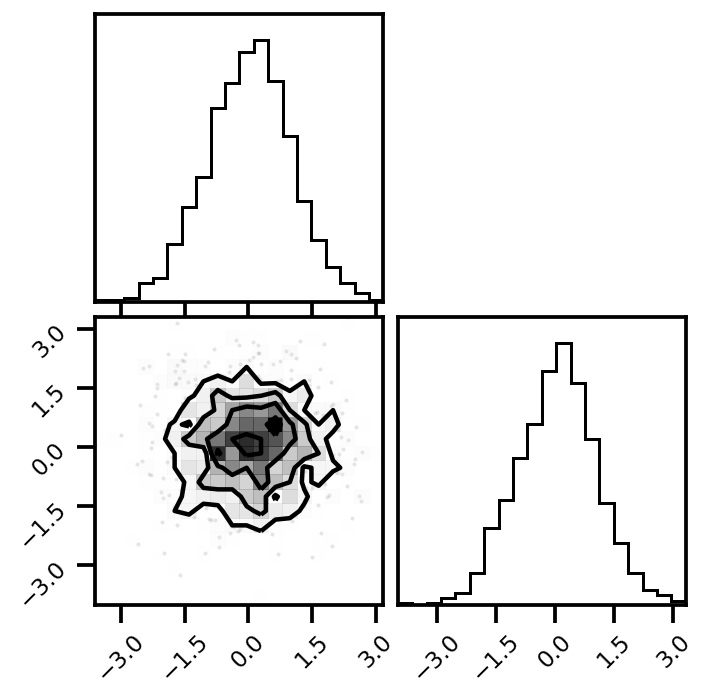

In [94]:
mus = reversed([0.000001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99999])
noise = 0.1
for i in mus:
    x = np.random.multivariate_normal(mean=[0, 0], cov=[[1, i], [i, 1]], size=1_000)

    x[:, 0] += noise * np.random.rand(*x[:, 0].shape)

    mi = -0.5 * np.log(1 - i ** 2)

    fig, ax = plt.subplots()
    ax.scatter(x[:, 0], x[:, 1], s=10)
    ax.set(xticks=[], yticks=[], title=rf"$\rho={i:.1f}$, MI$={mi:.2f}$")
    plt.tight_layout()
    plt.show()
    wandb.log({f"rho_scatter_{i:.1f}": wandb.Image(fig)})

    plt.close(fig)

    fig = corner.corner(x, hist_factor=2)
    plt.show()
    wandb.log({f"rho_density_{i:.1f}": wandb.Image(fig)})
    plt.close(fig)

In [76]:
from pysim.data.information.gaussian import generate_gaussian_mi_data
from pysim.data.information.studentt import generate_studentt_mi_data
from hyppo.tools import indep_sim

from typing import NamedTuple


class MIResult(NamedTuple):
    time: float
    MI: float
    name: str


def get_sim_datasets(n_samples, n_features, noise, dataset="linear", **kwargs):

    #     if dataset == "linear":
    #         from hyppo.tools import linear as sim_linear

    #         res = sim_linear(n=n_samples, p=n_features, noise=noise)

    #     elif dataset == "exponential":
    #         from hyppo.tools import exponential as sim_exp

    #         res = sim_exp(n=n_samples, p=n_features, noise=noise)

    #     elif dataset == "quadratic":
    #         from hyppo.tools import quadratic as sim_quad

    #         res = sim_quad(n=n_samples, p=n_features, noise=noise)

    #     elif dataset == "sine":
    #         from hyppo.tools import sin_four_pi as sim_sine

    #         res = sim_sine(n=n_samples, p=n_features, noise=noise)

    #     elif dataset == "noise":
    #         from hyppo.tools import multiplicative_noise

    #         res = multiplicative_noise(n=n_samples, p=n_features)
    #     elif dataset == "independent":
    #         from hyppo.tools import indep_sim

    #         res = indep_sim(n=n_samples, p=n_features, noise=noise)
    #     else:
    #         raise ValueError(f"Unrecognized estimator.")
    try:
        return indep_sim(sim=dataset, n=n_samples, p=n_features, noise=noise)
    except TypeError:
        return indep_sim(sim=dataset, n=n_samples, p=n_features)


datasets = [
    "linear",
    "exponential",
    "quadratic",
    "sin_four_pi",
    "multiplicative_noise",
    "multimodal_independence",
]

Dataset: linear:   0%|          | 0/6 [00:00<?, ?it/s]

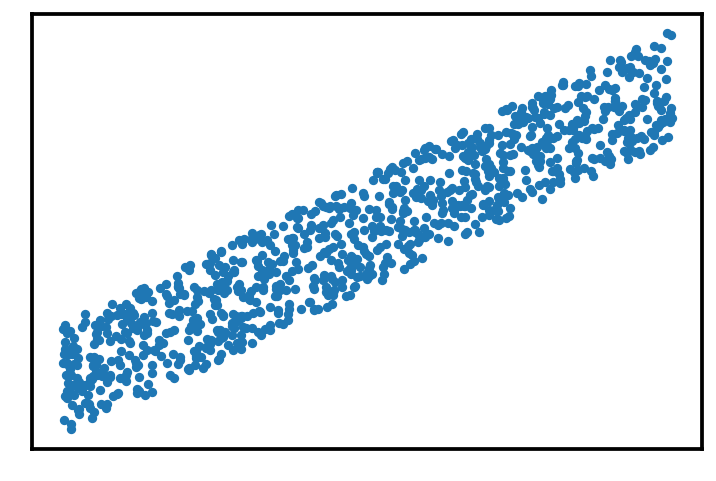

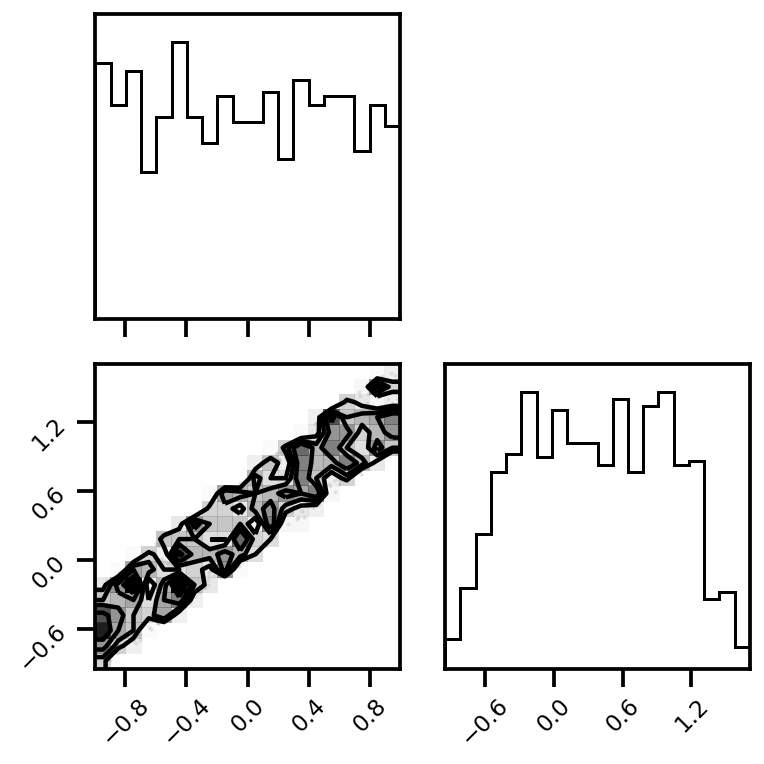

Dataset: exponential:  17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

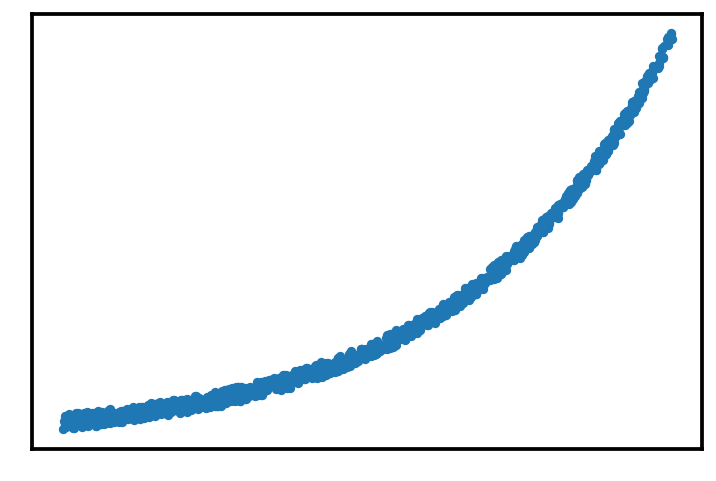

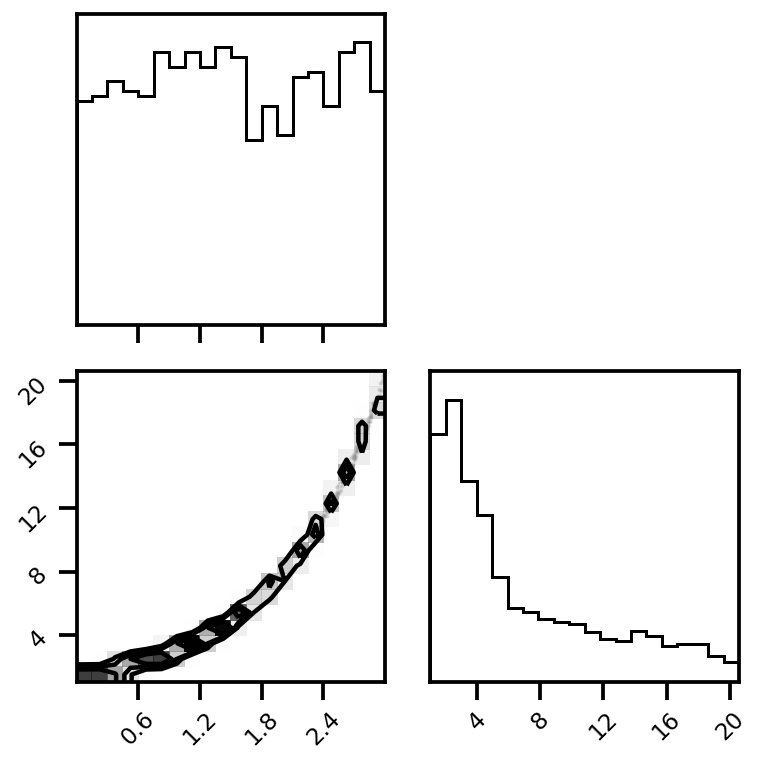

Dataset: quadratic:  33%|███▎      | 2/6 [00:01<00:02,  1.87it/s]  

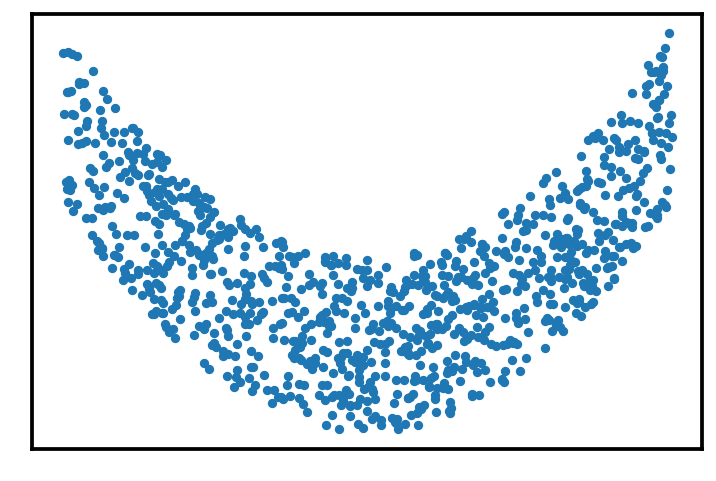

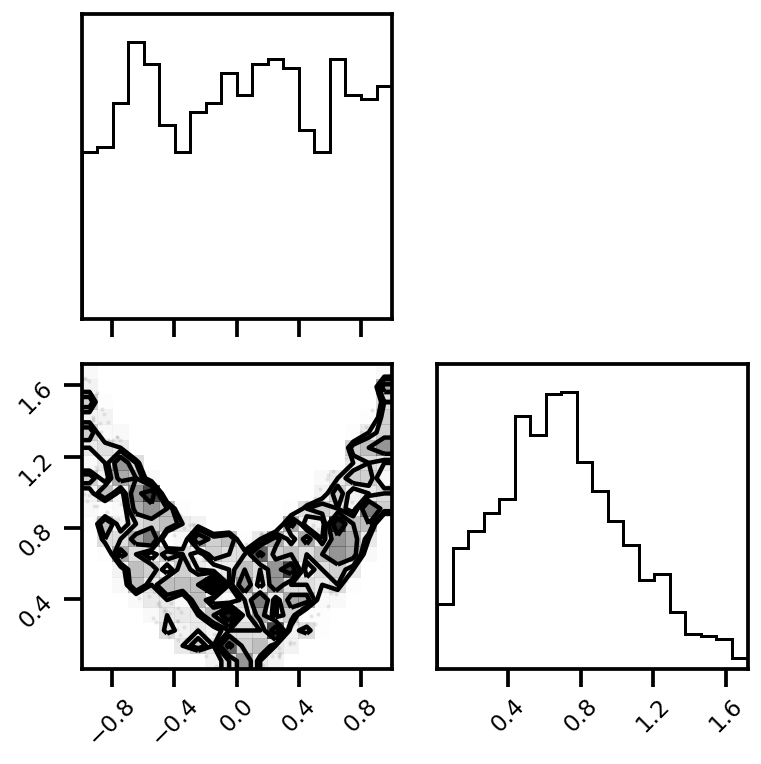

Dataset: sin_four_pi:  50%|█████     | 3/6 [00:01<00:01,  1.98it/s]

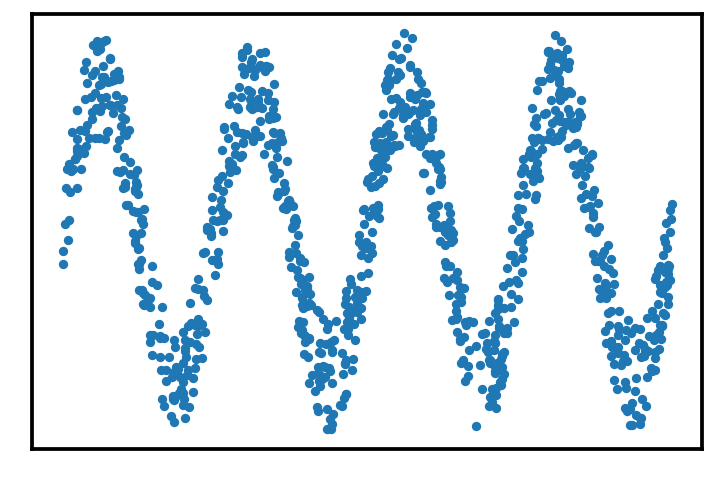

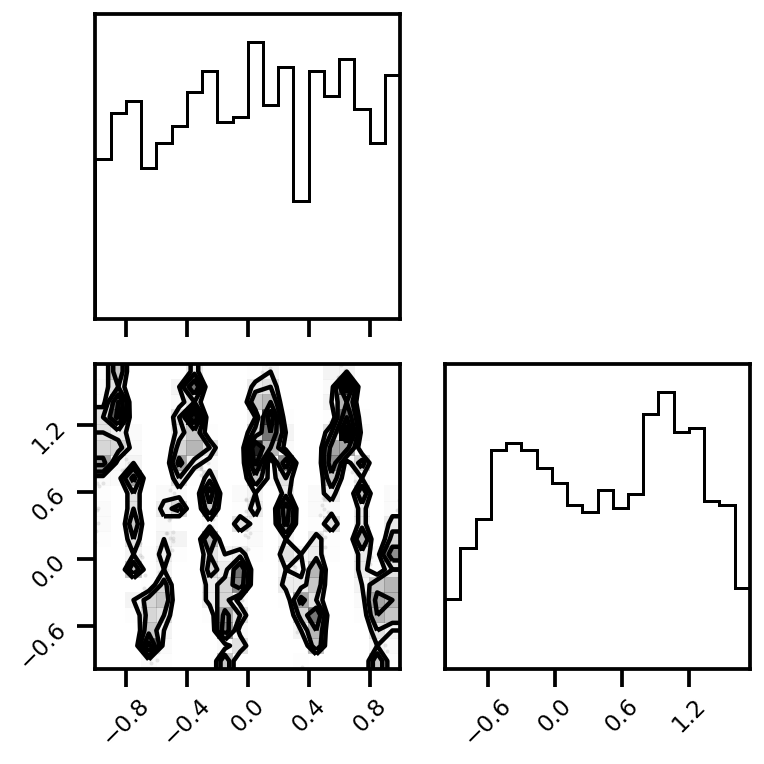

Dataset: multiplicative_noise:  67%|██████▋   | 4/6 [00:02<00:00,  2.04it/s]

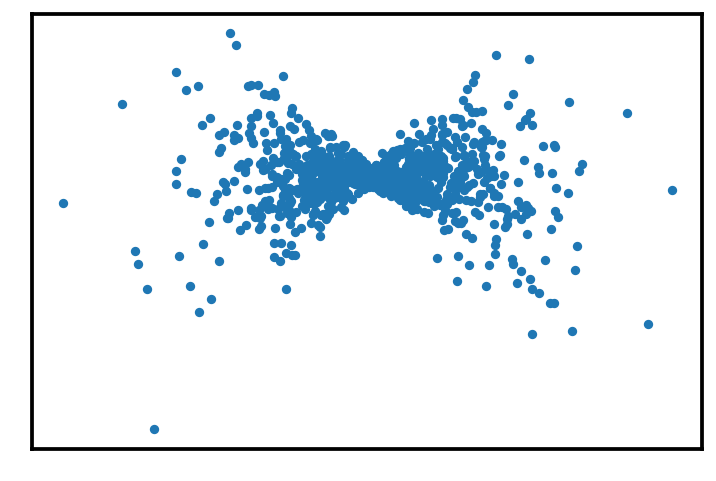

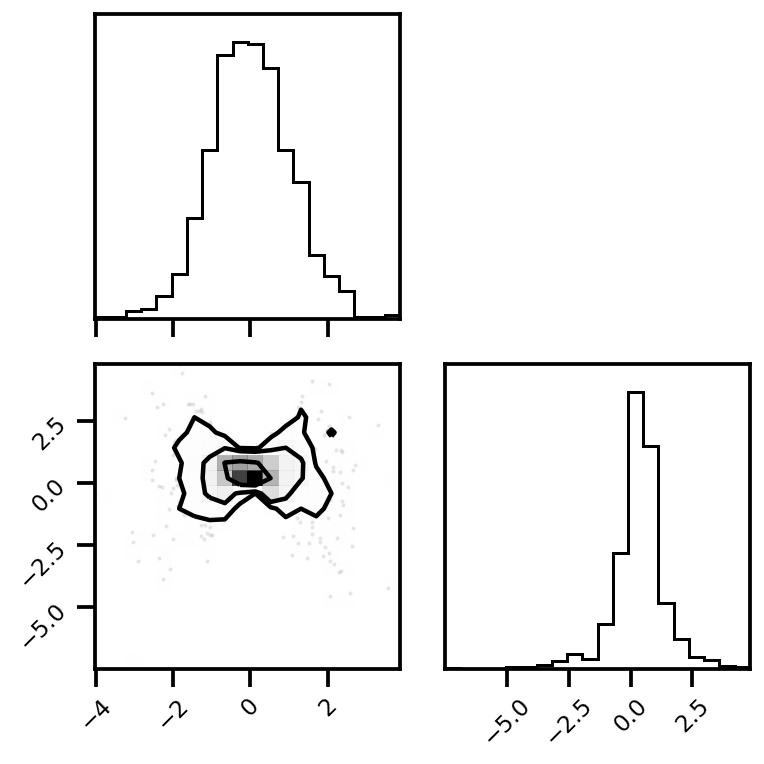

Dataset: multimodal_independence:  83%|████████▎ | 5/6 [00:02<00:00,  2.12it/s]

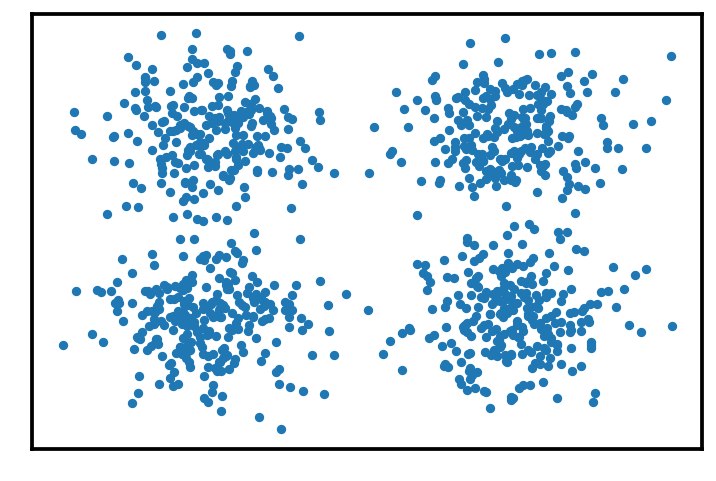

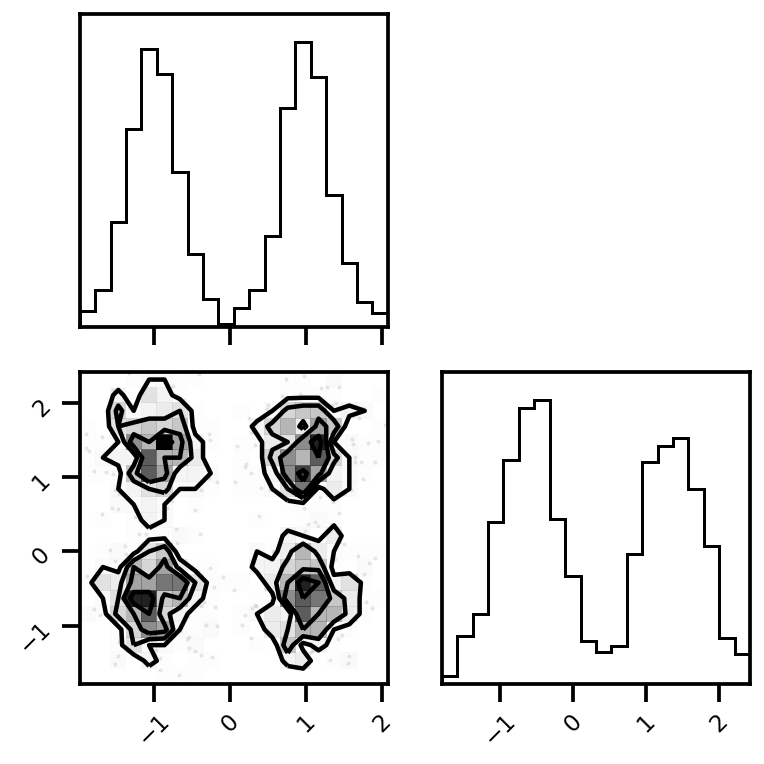

Dataset: multimodal_independence: 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]


In [79]:
import tqdm
import pandas as pd


n_samples = 1_000
n_features = 1
noise = 0.75

with tqdm.tqdm(datasets) as pbar:

    for idataset in pbar:

        pbar.set_description(f"Dataset: {idataset}")

        # generate data
        X, Y = get_sim_datasets(
            n_samples=n_samples, n_features=n_features, noise=False, dataset=idataset,
        )

        Y += noise * np.random.rand(*Y.shape)

        fig, ax = plt.subplots()

        ax.scatter(X.ravel(), Y.ravel(), s=10)
        ax.set(xticks=[], yticks=[])
        plt.show()
        wandb.log({f"scatter_{idataset}": wandb.Image(fig)})
        plt.close(fig)

        fig = corner.corner(np.concatenate([X, Y], axis=1), hist_factor=2)
        plt.tight_layout()
        plt.show()
        wandb.log({f"density_{idataset}": wandb.Image(fig)})
        plt.close(fig)

### Transformation

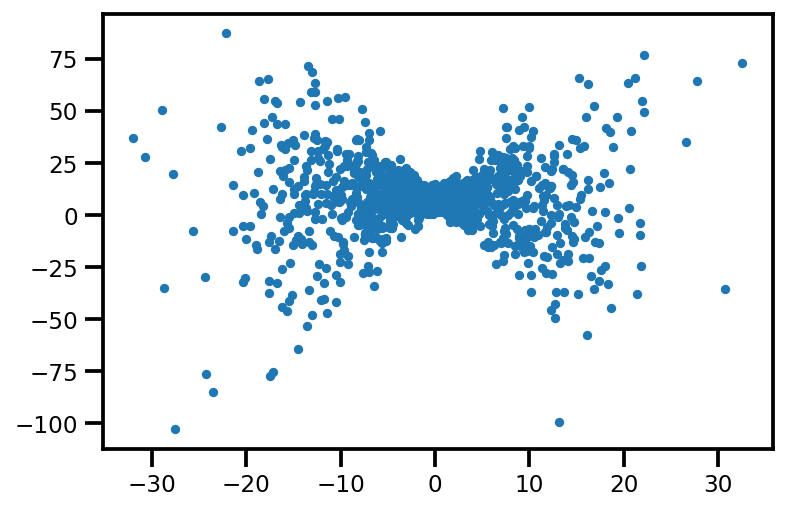

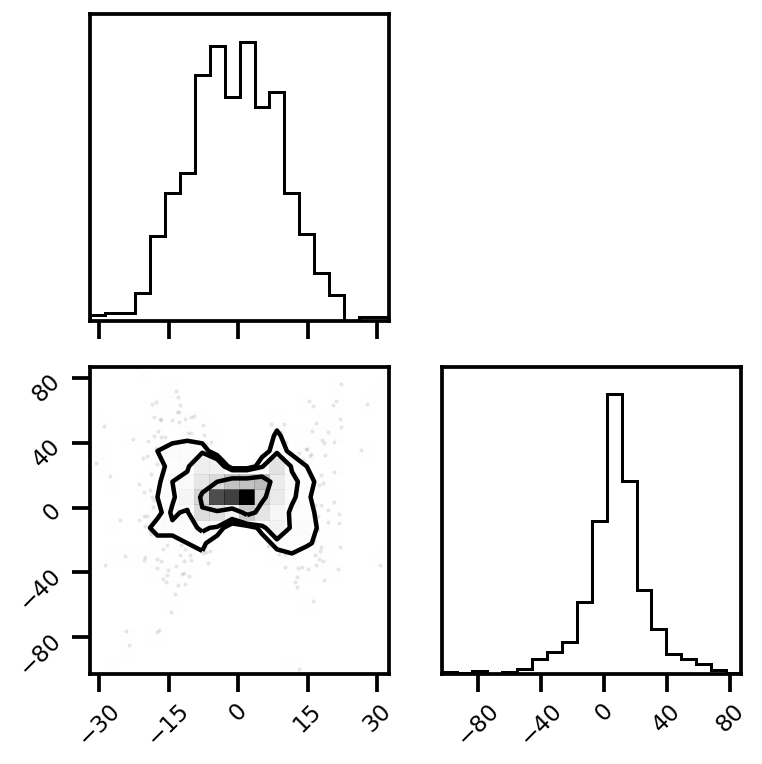

In [27]:
idataset = "multiplicative_noise"

# generate data
X, Y = get_sim_datasets(
    n_samples=n_samples, n_features=n_features, noise=False, dataset=idataset,
)

Y += noise * np.random.rand(*Y.shape)

X *= 10.0
Y *= 20

fig, ax = plt.subplots()

ax.scatter(X.ravel(), Y.ravel(), s=10)
plt.show()
wandb.log({f"scatter_{idataset}": wandb.Image(fig)})
plt.close(fig)

fig = corner.corner(np.concatenate([X, Y], axis=1), hist_factor=2)
plt.tight_layout()
plt.show()
wandb.log({f"density_{idataset}": wandb.Image(fig)})
plt.close(fig)

#### Isotropic Scaling

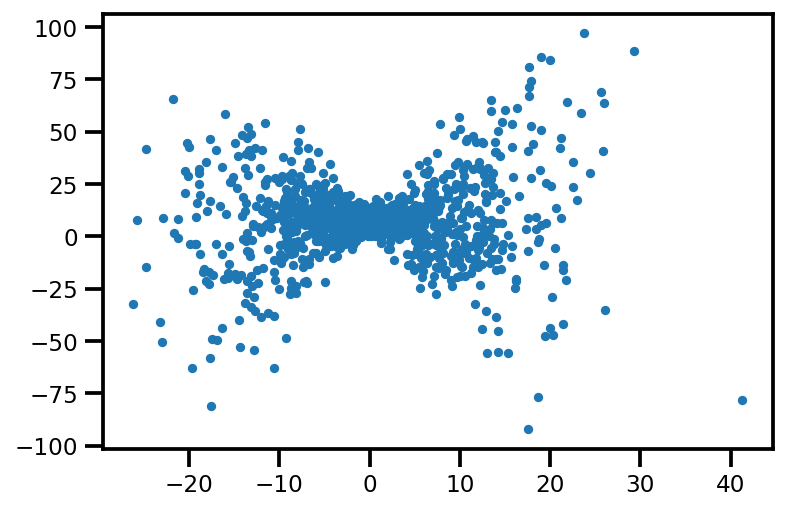

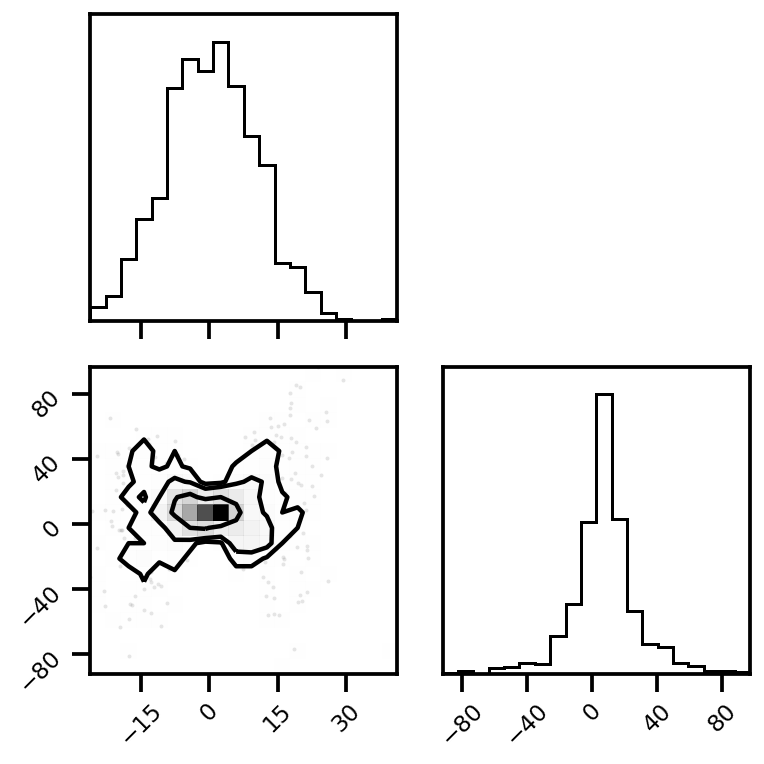

In [28]:
idataset = "multiplicative_noise"

# generate data
X, Y = get_sim_datasets(
    n_samples=n_samples, n_features=n_features, noise=False, dataset=idataset,
)

Y += noise * np.random.rand(*Y.shape)

X *= 10.0
Y *= 20

fig, ax = plt.subplots()

ax.scatter(X.ravel(), Y.ravel(), s=10)
plt.show()
wandb.log({f"iso_scatter_{idataset}": wandb.Image(fig)})
plt.close(fig)

fig = corner.corner(np.concatenate([X, Y], axis=1), hist_factor=2)
plt.tight_layout()
plt.show()
wandb.log({f"iso_density_{idataset}": wandb.Image(fig)})
plt.close(fig)

#### Scaling

In [40]:
(0.001 * np.exp(Y)).min(), (0.001 * np.exp(0.01 * Y)).max()

(4.0512528868965927e-41, 0.002433128078522583)

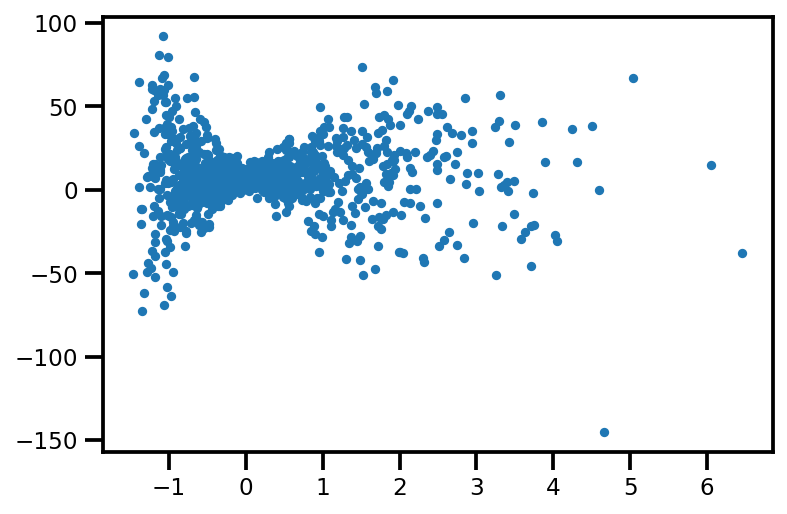

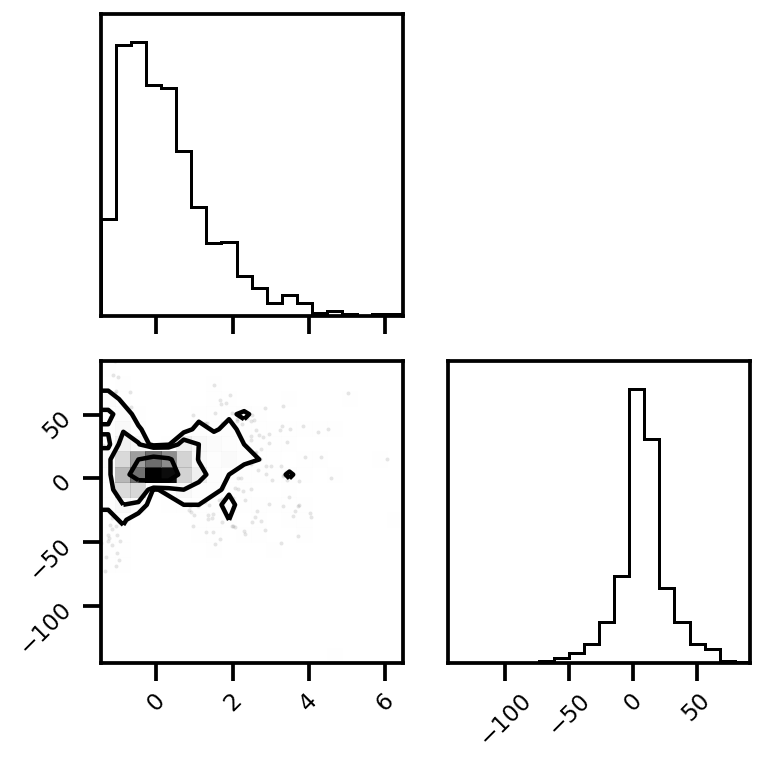

In [46]:
idataset = "multiplicative_noise"

# generate data
X, Y = get_sim_datasets(
    n_samples=n_samples, n_features=n_features, noise=False, dataset=idataset,
)

Y += noise * np.random.rand(*Y.shape)

X *= np.exp(0.25 * X)
Y *= 20

fig, ax = plt.subplots()

ax.scatter(X.ravel(), Y.ravel(), s=10)
plt.show()
wandb.log({f"scale_scatter_{idataset}": wandb.Image(fig)})
plt.close(fig)

fig = corner.corner(np.concatenate([X, Y], axis=1), hist_factor=2)
plt.tight_layout()
plt.show()
wandb.log({f"scale_density_{idataset}": wandb.Image(fig)})
plt.close(fig)

#### Orthogonal

In [21]:
from sklearn.decomposition import PCA

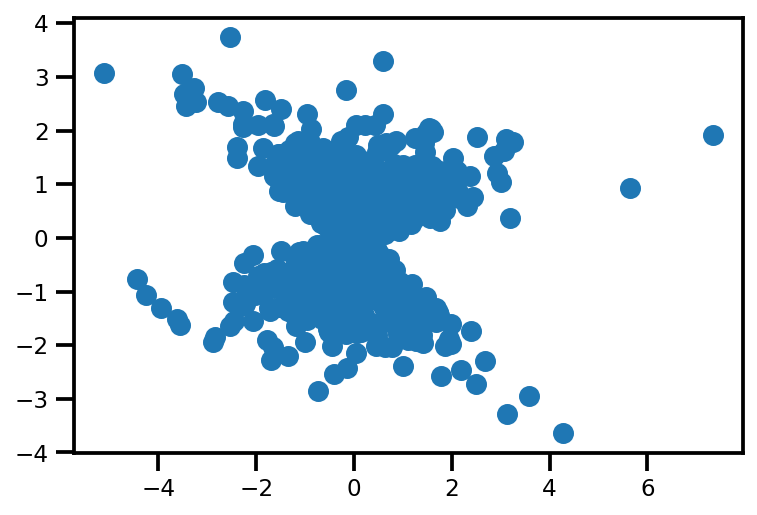

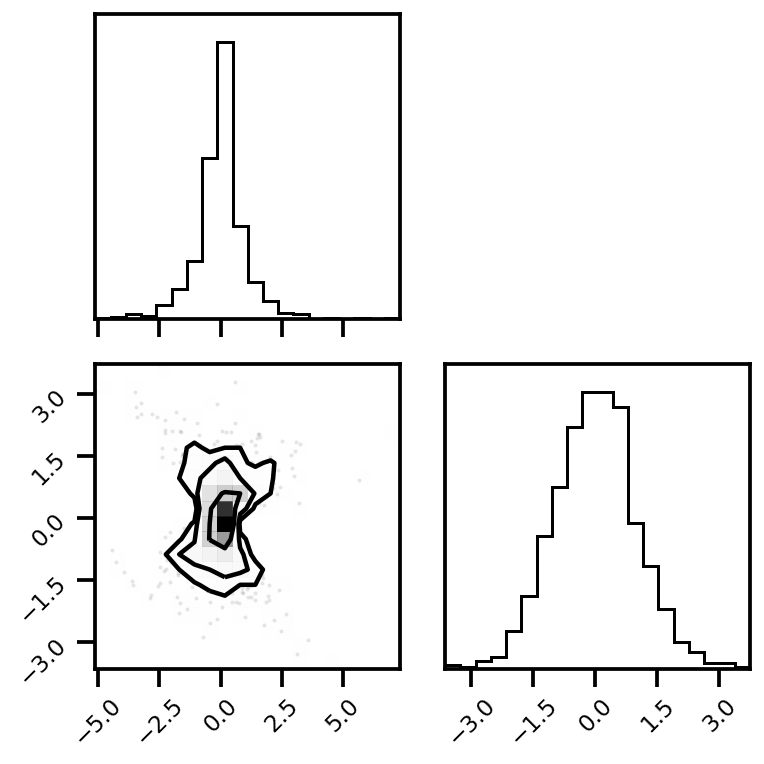

In [63]:
# generate data
X, Y = get_sim_datasets(
    n_samples=n_samples, n_features=n_features, noise=False, dataset=idataset,
)

Y += noise * np.random.rand(*Y.shape)

data = np.hstack([X, Y])
data_rot = PCA().fit_transform(data)

X, Y = data_rot[:, 0], data_rot[:, 1]

fig, ax = plt.subplots()

ax.scatter(X.ravel(), Y.ravel())
plt.show()
wandb.log({f"ortho_scatter_{idataset}": wandb.Image(fig)})
plt.close(fig)

fig = corner.corner(data_rot, hist_factor=2)
plt.tight_layout()
plt.show()
wandb.log({f"ortho_density_{idataset}": wandb.Image(fig)})
plt.close(fig)

#### Invertible

In [67]:
X.min(), X.max()

(nan, nan)

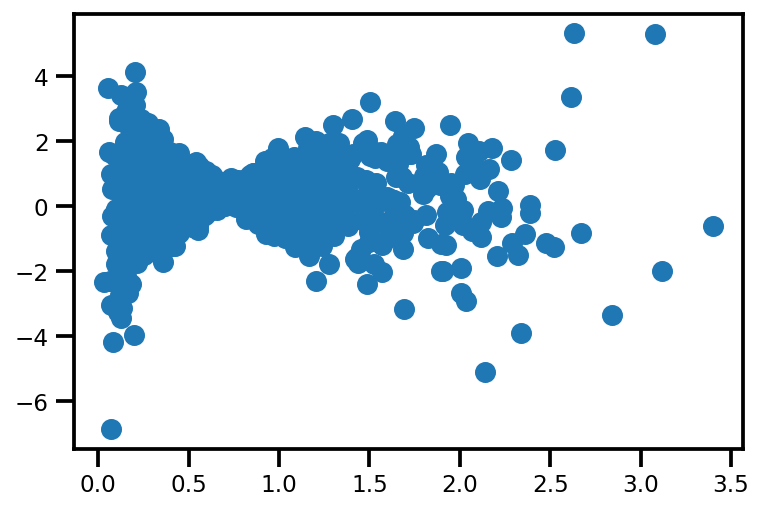

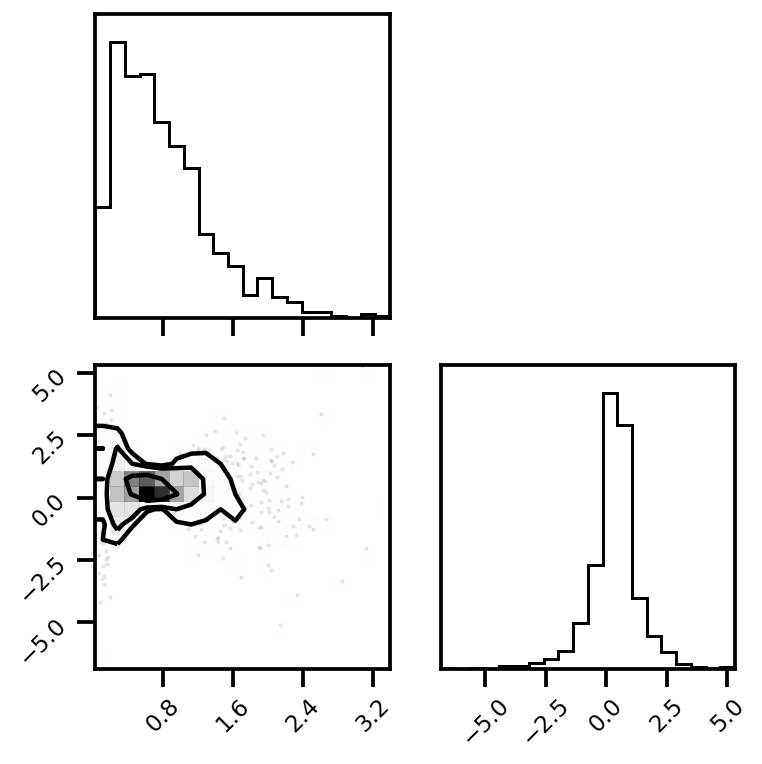

In [75]:
# generate data
X, Y = get_sim_datasets(
    n_samples=n_samples, n_features=n_features, noise=False, dataset=idataset,
)

Y += noise * np.random.rand(*Y.shape)

X = np.log(1 + np.exp(X))

fig, ax = plt.subplots()

ax.scatter(X.ravel(), Y.ravel())
plt.show()
wandb.log({f"invert_scatter_{idataset}": wandb.Image(fig)})
plt.close(fig)

fig = corner.corner(np.concatenate([X, Y], axis=1), hist_factor=2)
plt.tight_layout()
plt.show()
wandb.log({f"invert_density_{idataset}": wandb.Image(fig)})
plt.close(fig)

### Estimators

In [8]:
# !pip install "git+https://github.com/gregversteeg/NPEET.git"
# !pip install mutual-info

In [9]:
from mutual_info.mutual_info import mutual_information as mi_mutual_info
from npeet.entropy_estimators import mi as npeet_mutual_info

In [10]:
from pysim.information.gaussian import gauss_entropy_multi
from pysim.information.knn import knn_entropy, knn_entropy_npeet
from pysim.information.mutual import multivariate_mutual_information
import time


def get_mi_estimators(X, Y, method="gaussian", **kwargs):

    if method == "gaussian":
        t0 = time.time()
        res = multivariate_mutual_information(
            X=X.copy(), Y=Y.copy(), f=gauss_entropy_multi
        )
        t1 = time.time() - t0
        return MIResult(t1, res.MI, "gaussian")

    elif method == "knn_nbs":
        t0 = time.time()
        res = mi_mutual_info((X.copy(), Y.copy()), k=kwargs.get("k", 5), transform=None)
        t1 = time.time() - t0
        return MIResult(t1, res, "knn_nbs")

    elif method == "knn_eps":
        t0 = time.time()
        res = npeet_mutual_info(
            x=X.copy(), y=Y.copy(), base=np.e, k=kwargs.get("k", 5),
        )
        t1 = time.time() - t0
        return MIResult(t1, res, "knn_eps")

    elif method == "rv":
        from hyppo.independence import RV

        t0 = time.time()
        res = res = RV().statistic(x=X.copy(), y=Y.copy())
        t1 = time.time() - t0
        return MIResult(t1, res, "rv")

    elif method == "nhsic_lin":
        from hyppo.independence import Hsic

        t0 = time.time()
        hsic_model = Hsic(compute_kernel="linear")
        res = hsic_model.statistic(x=X.copy(), y=Y.copy())
        t1 = time.time() - t0
        return MIResult(t1, res, "nhsic_lin")

    elif method == "nhsic_rbf":
        from hyppo.independence import Hsic

        t0 = time.time()
        hsic_model = Hsic(compute_kernel="rbf")
        res = hsic_model.statistic(x=X.copy(), y=Y.copy())
        t1 = time.time() - t0
        return MIResult(t1, res, "nhsic_rbf")

    elif method == "mmd":
        from hyppo.ksample import MMD

        t0 = time.time()
        res = MMD(compute_kernel="gaussian").statistic(x=X.copy(), y=Y.copy())
        t1 = time.time() - t0
        return MIResult(t1, res, "mmd")
    else:
        raise ValueError(f"Unrecognized estimator.")

## Toy Data

In [18]:
from pysim.utils import dict_product

params = {
    "n_samples": [1_000, 2_000, 5_000],
    "n_features": [1,],
    "n_trials": list(np.arange(1, 10)),
    "dataset": datasets,
    "noise": [True, False],
}
params = dict_product(params)

models = ["gaussian", "rv", "knn_nbs", "knn_eps", "nhsic_lin", "nhsic_rbf", "mmd"]

### Gaussian

**Implementation Notes**:

1. We randomly generate a positive semi-definite $D \times D$ matrix. This acts as our covariance matrix $\boldsymbol{\Sigma}$.

2. We use a mean, $\boldsymbol{\mu}$ of $\mathbf{0}$.

3. We generate an upper limit of 5e5 data points and then random subset the requested number.

In [16]:
from functools import partial
from tqdm.autonotebook import tqdm, trange

In [19]:
import tqdm
import pandas as pd

results_df = pd.DataFrame()
results_dict = {}

with tqdm.tqdm(params) as pbar:

    for i, iparam in enumerate(pbar):

        pbar.set_description(
            f"Samples: {iparam['n_samples']} | Features: {iparam['n_features']} | Trial: {iparam['n_trials']} | Dataset: {iparam['dataset']}"
        )

        # generate data
        X, Y = get_sim_datasets(
            n_samples=iparam["n_samples"],
            n_features=iparam["n_features"],
            noise=iparam["noise"],
            dataset=iparam["dataset"],
        )

        # GAUSSIAN APPROXIMATION

        #         with tqdm.tqdm(models, leave=False) as pbar_models:
        for imodel in models:

            pbar.set_description(
                f"Samples: {iparam['n_samples']} | Features: {iparam['n_features']} | Trial: {iparam['n_trials']} | Dataset: {iparam['dataset']} | Model: {imodel}"
            )

            # KNN (NEIGHBOURS)

            # do calculation
            res = get_mi_estimators(X=X.copy(), Y=Y.copy(), method=imodel)

            results_dict = {**results_dict, **iparam}
            results_dict["model"] = res.name
            results_dict["dataset"] = iparam["dataset"]
            results_dict["approx"] = res.MI
            results_dict["time"] = res.time
            results_dict["noise"] = iparam["n_features"]
            results_dict["n_samples"] = iparam["n_samples"]
            results_dict["n_features"] = iparam["n_features"]
            results_dict["n_trials"] = iparam["n_trials"]

            results_df = pd.concat(
                [results_df, pd.DataFrame(results_dict, index=[i])], axis=0
            )

Samples: 5000 | Features: 1 | Trial: 9 | Dataset: multimodal_independence | Model: mmd: 100%|██████████| 324/324 [38:41<00:00,  7.17s/it]      


In [ ]:
results_df.tail()

In [110]:
wandb.log({"sim_results": wandb.Table(dataframe=results_df)})

In [26]:
results_df_approx = results_df.copy()

In [141]:
def create_results_xr(df):

    # get the ground

    # drop columns
    df = df.drop(columns=["noise"], axis=0)

    # make index the experiment params
    df = df.set_index(["model", "n_samples", "n_features", "n_trials", "dataset"])

    #
    df_xr = df.to_xarray()

    return df_xr

In [143]:
results_xr = create_results_xr(results_df)
results_xr

<xarray.Dataset>
Dimensions:     (dataset: 6, model: 7, n_features: 1, n_samples: 4, n_trials: 20)
Coordinates:
  * model       (model) object 'gaussian' 'knn_eps' ... 'nhsic_rbf' 'rv'
  * n_samples   (n_samples) int64 100 1000 2000 5000
  * n_features  (n_features) int64 1
  * n_trials    (n_trials) int64 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20
  * dataset     (dataset) object 'exponential' 'linear' ... 'sin_four_pi'
Data variables:
    approx      (model, n_samples, n_features, n_trials, dataset) float64 0.1...
    time        (model, n_samples, n_features, n_trials, dataset) float64 0.0...

## Results

### Demo Plot

In [ ]:


with tqdm.tqdm(params) as pbar:

    for i, iparam in enumerate(pbar):

        pbar.set_description(
            f"Samples: {iparam['n_samples']} | Features: {iparam['n_features']} | Trial: {iparam['n_trials']} | Dataset: {iparam['dataset']}"
        )


        # GAUSSIAN APPROXIMATION

        #         with tqdm.tqdm(models, leave=False) as pbar_models:
        for imodel in models:

            pbar.set_description(
                f"Samples: {iparam['n_samples']} | Features: {iparam['n_features']} | Trial: {iparam['n_trials']} | Dataset: {iparam['dataset']} | Model: {imodel}"
            )

            # KNN (NEIGHBOURS)
            
            


            results_dict["model"] = res.name
            results_dict["dataset"] = iparam["dataset"]
            results_dict["approx"] = res.MI
            results_dict["time"] = res.time
            results_dict["noise"] = True
            results_dict["n_samples"] = iparam["n_samples"]
            results_dict["n_features"] = iparam["n_features"]
            results_dict["n_trials"] = iparam["n_trials"]


In [60]:
df_knn, df_true = get_mu_std(results_df, "gaussian")

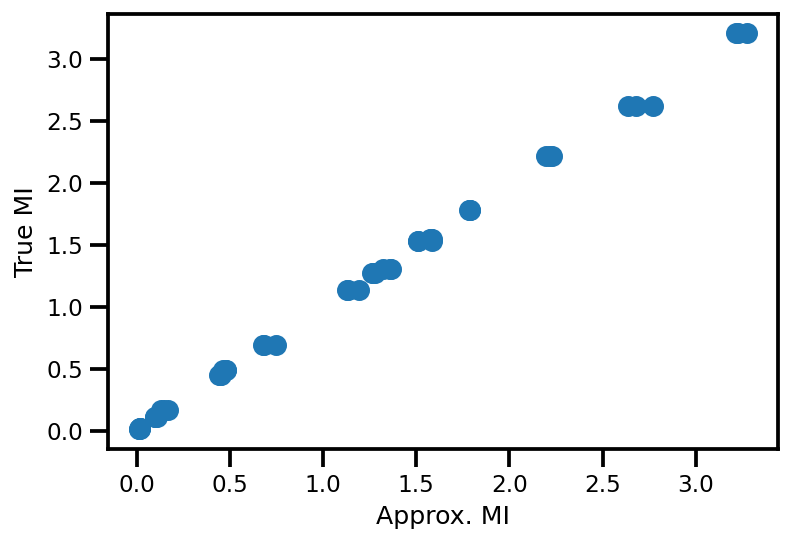

In [61]:
fig, ax = plt.subplots()

ax.scatter(df_knn.values, df_true.values)
ax.set(xlabel="Approx. MI", ylabel="True MI")
plt.show()

## Results

In [169]:
def plot_results(results_xr, model="gaussian", dataset="linear"):

    results_xr = results_xr.sel(model=model, dataset=dataset)
    results_xr = results_xr.mean(["n_trials"])

    fig, ax = plt.subplots()

    score = results_xr.approx.values

    ax.plot(results_xr.n_samples.values, results_xr.approx.values)
    ax.set(xlabel="Number of Samples", ylabel="Score")
    ax.set_title(f"Dataset - {dataset} | Model - {model} | Score - {score.mean():.4f}")
    plt.tight_layout()
    plt.show()
    wandb.log({f"score_{dataset}_{model}": wandb.Image(plt)})
    plt.close(fig)

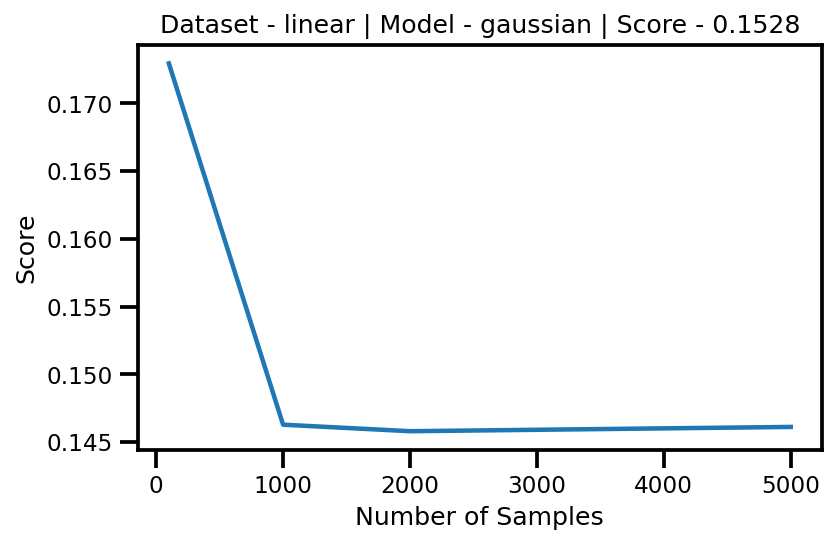

<Figure size 432x288 with 0 Axes>

In [170]:
plot_results(results_xr, model="gaussian", dataset="linear")

### Gaussian Distribution

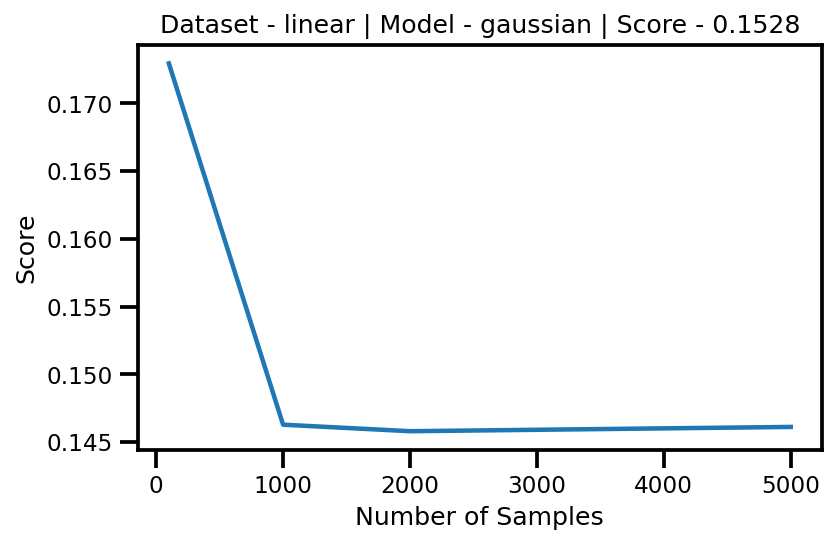

<Figure size 432x288 with 0 Axes>

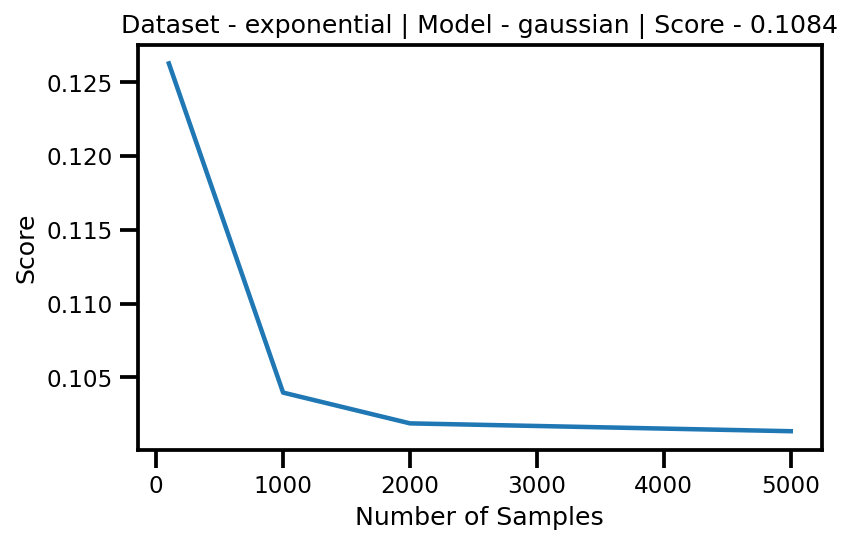

<Figure size 432x288 with 0 Axes>

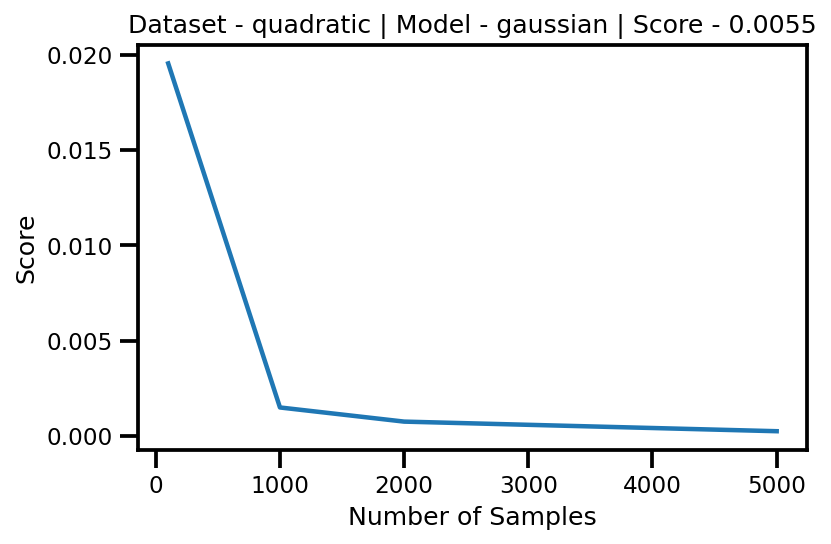

<Figure size 432x288 with 0 Axes>

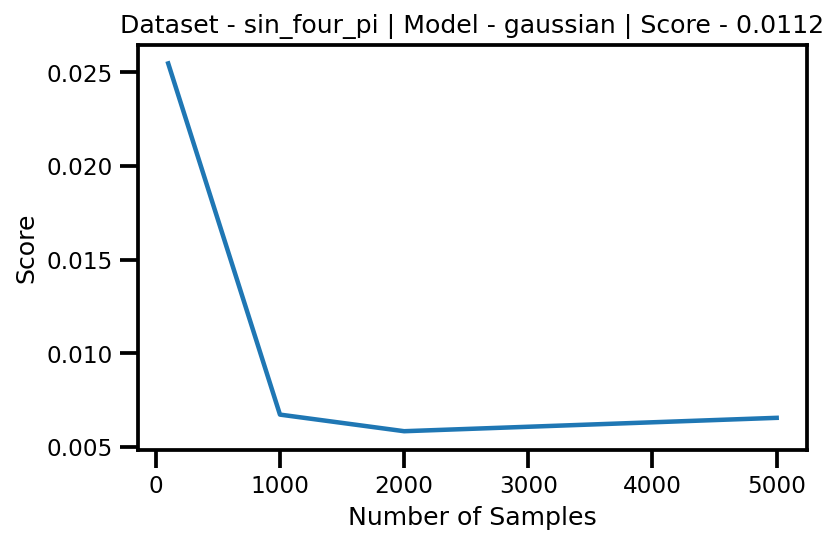

<Figure size 432x288 with 0 Axes>

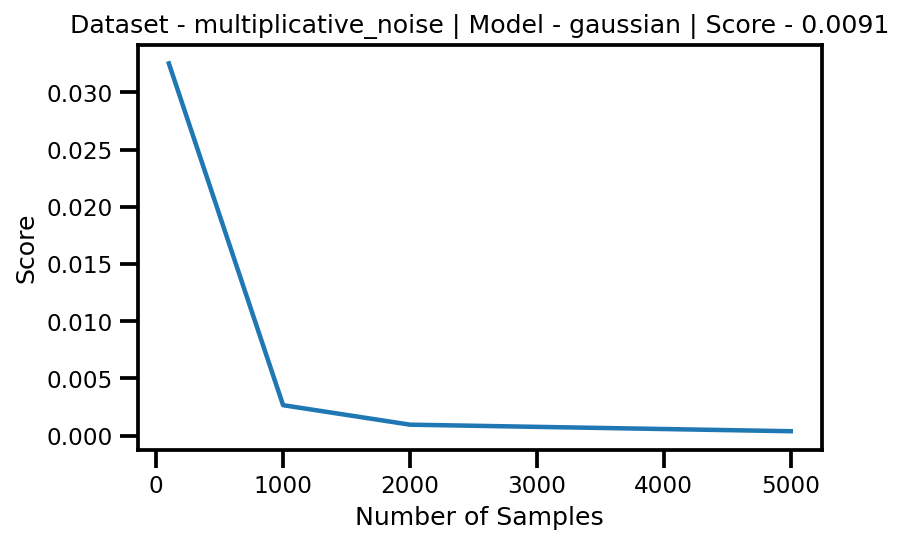

<Figure size 432x288 with 0 Axes>

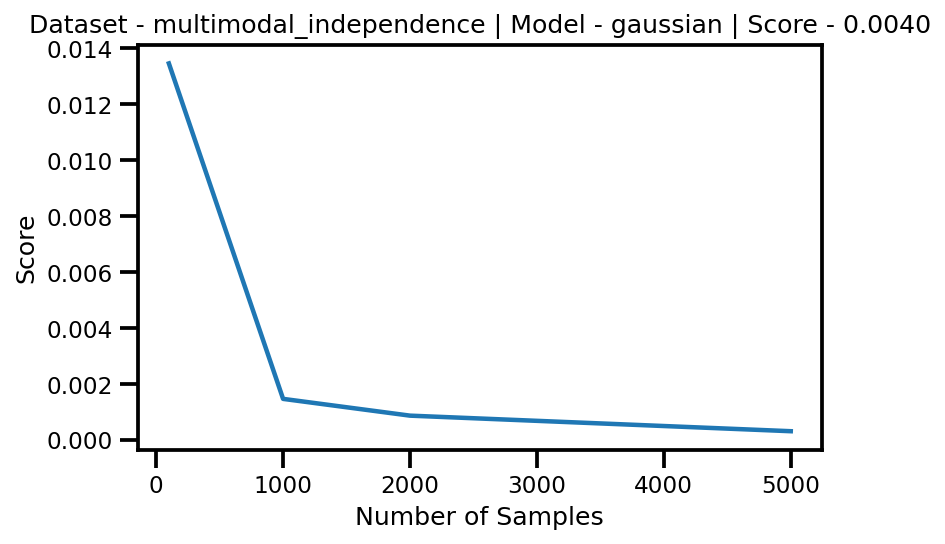

<Figure size 432x288 with 0 Axes>

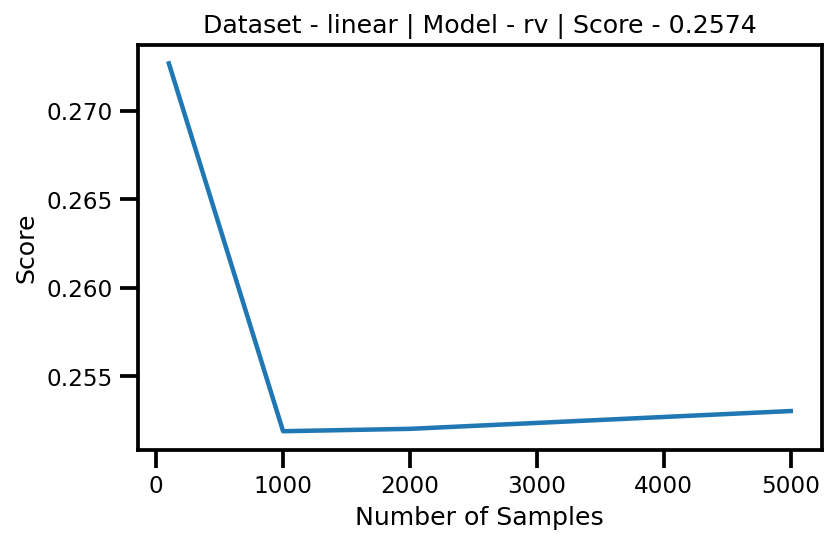

<Figure size 432x288 with 0 Axes>

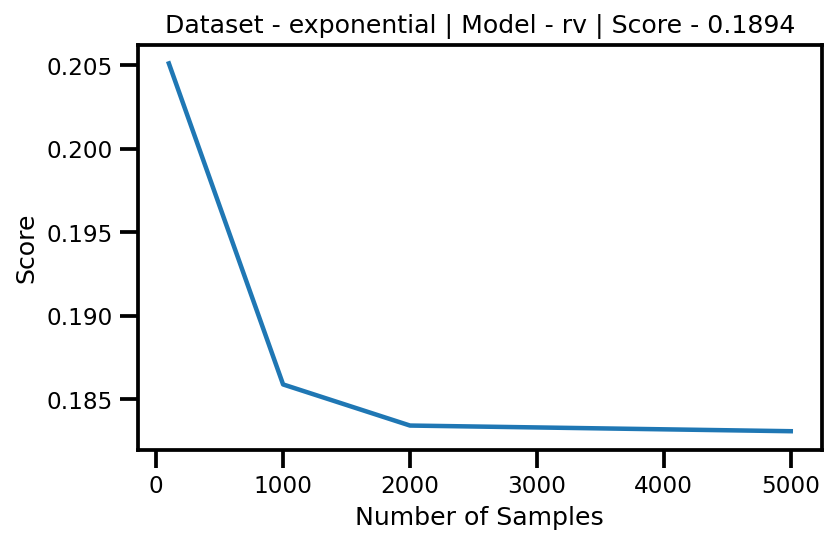

<Figure size 432x288 with 0 Axes>

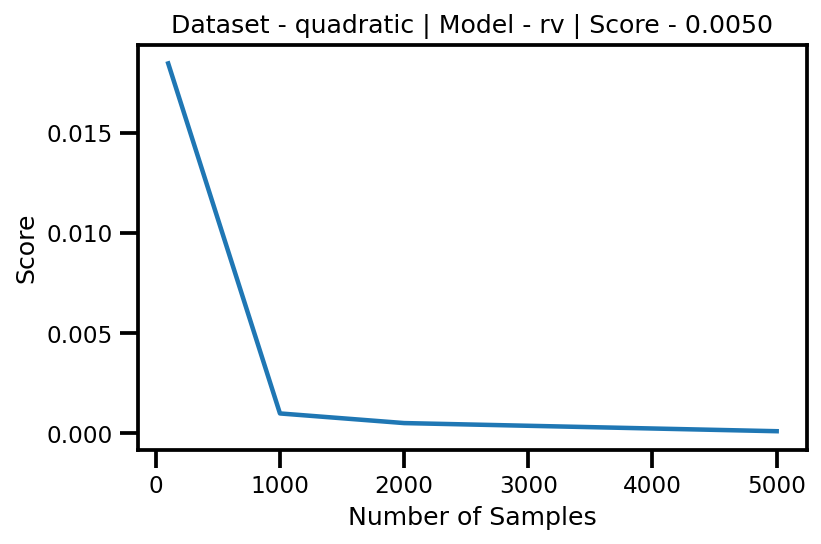

<Figure size 432x288 with 0 Axes>

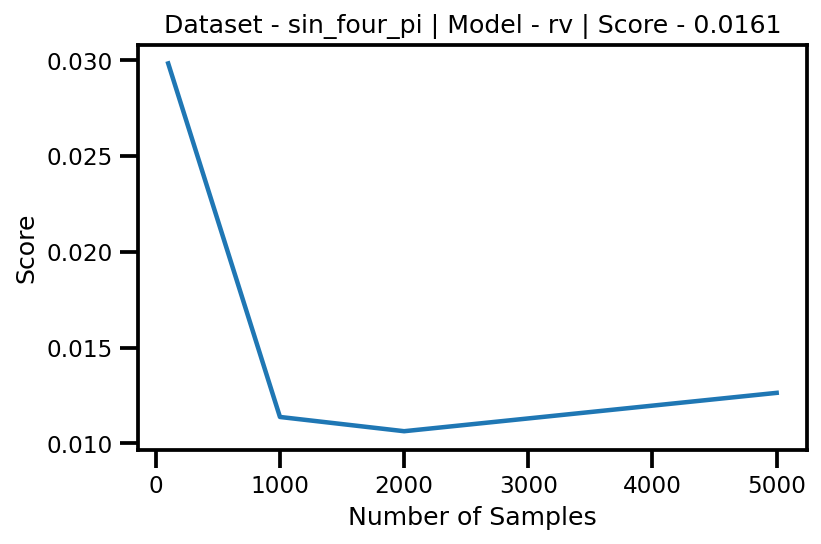

<Figure size 432x288 with 0 Axes>

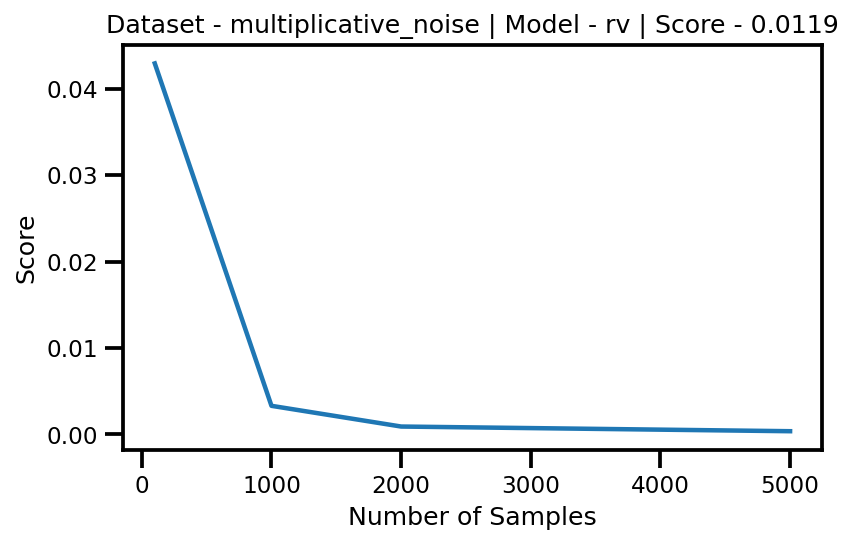

<Figure size 432x288 with 0 Axes>

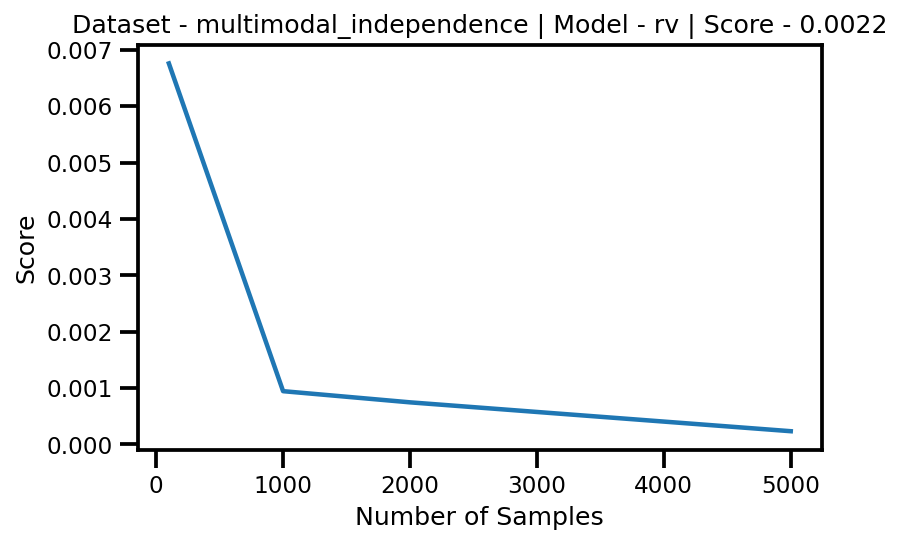

<Figure size 432x288 with 0 Axes>

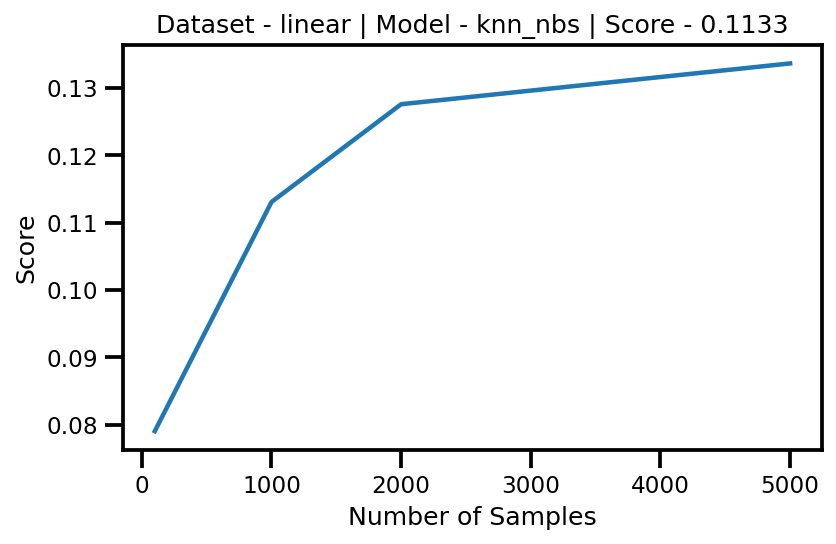

<Figure size 432x288 with 0 Axes>

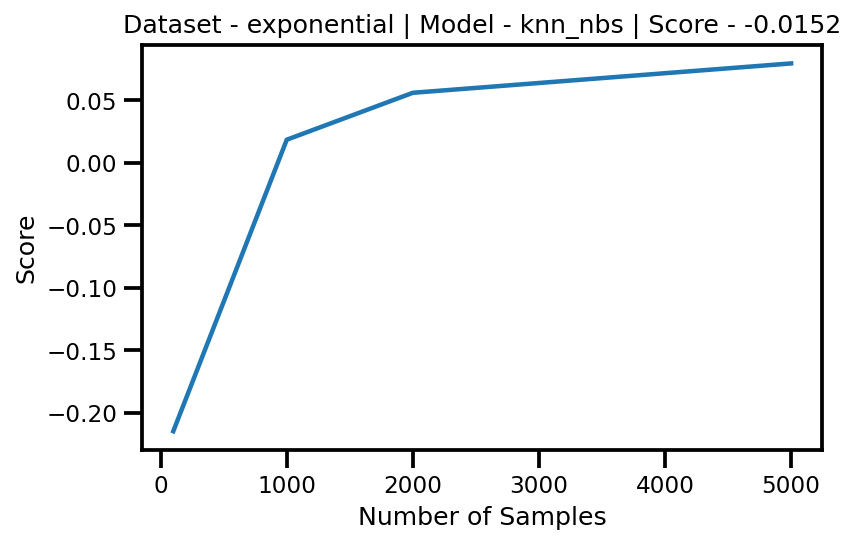

<Figure size 432x288 with 0 Axes>

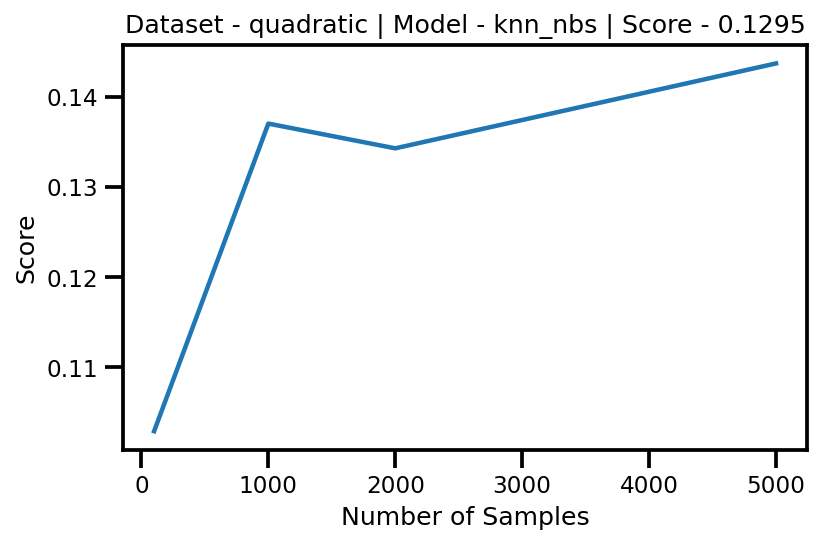

<Figure size 432x288 with 0 Axes>

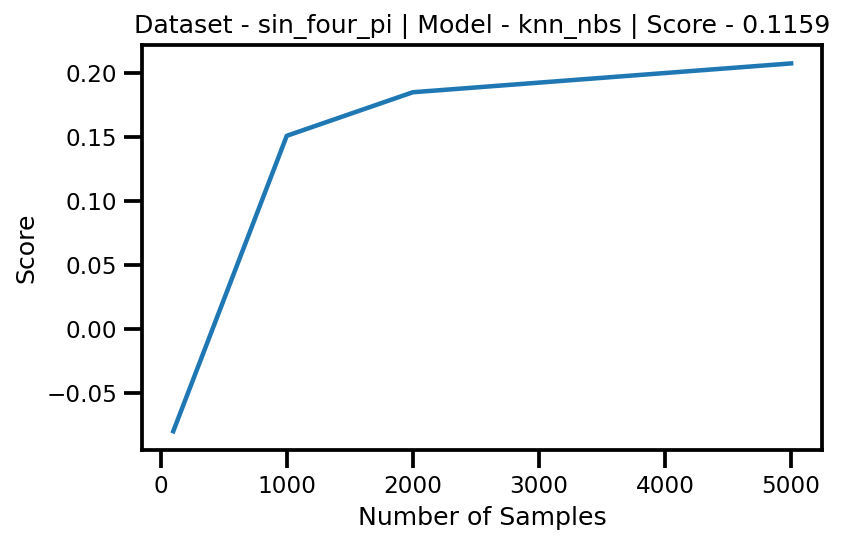

<Figure size 432x288 with 0 Axes>

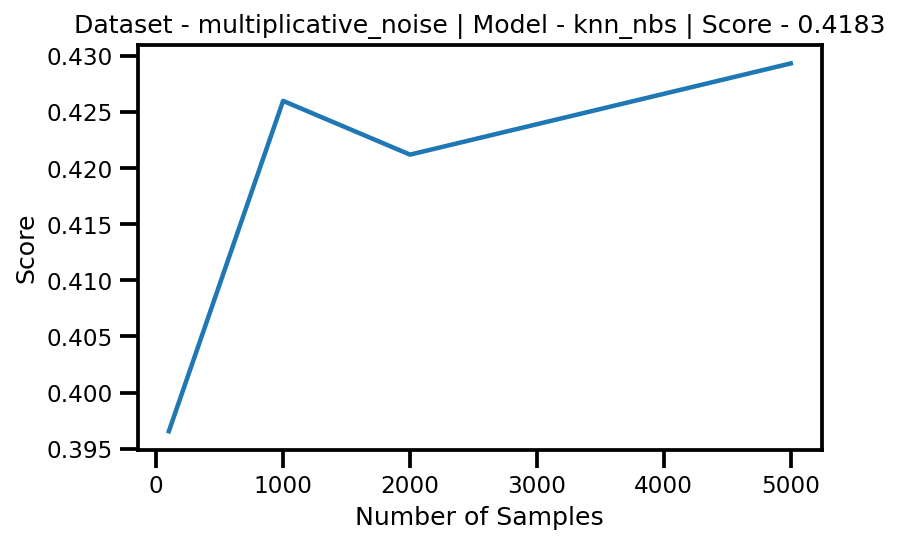

<Figure size 432x288 with 0 Axes>

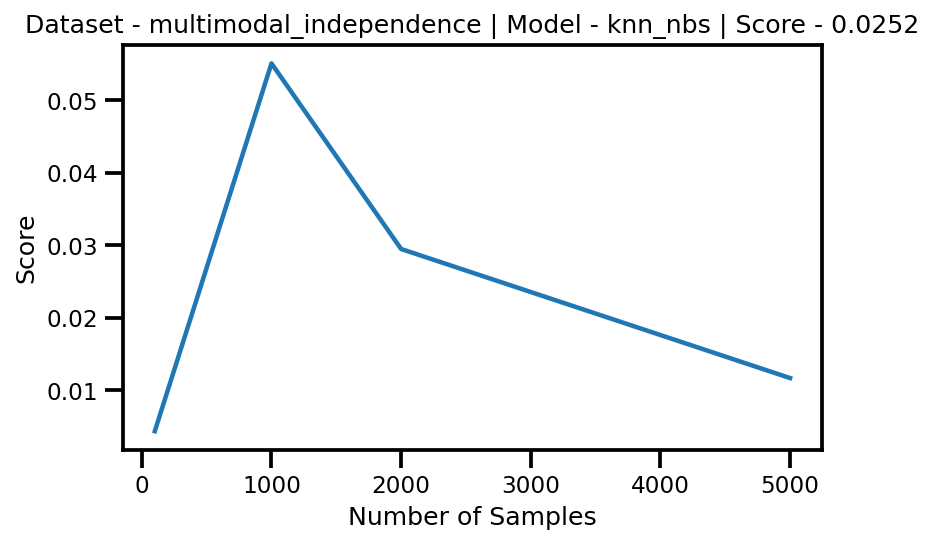

<Figure size 432x288 with 0 Axes>

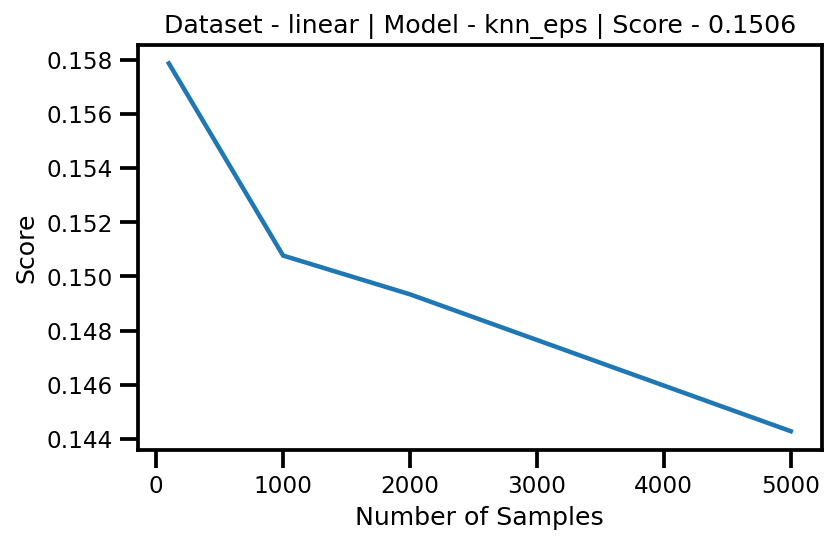

<Figure size 432x288 with 0 Axes>

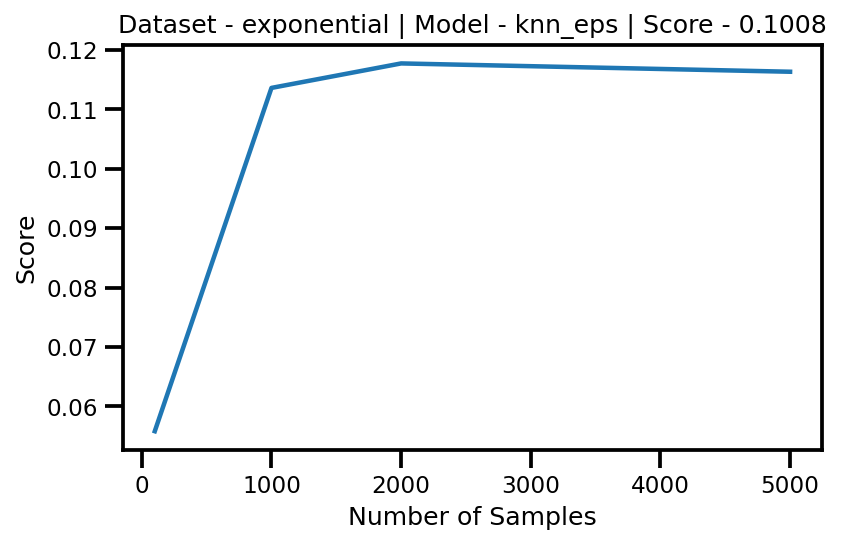

<Figure size 432x288 with 0 Axes>

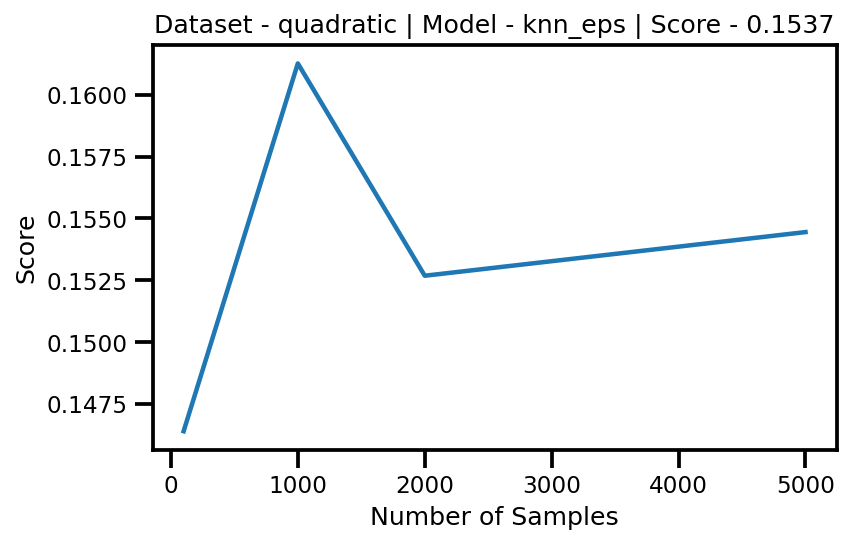

<Figure size 432x288 with 0 Axes>

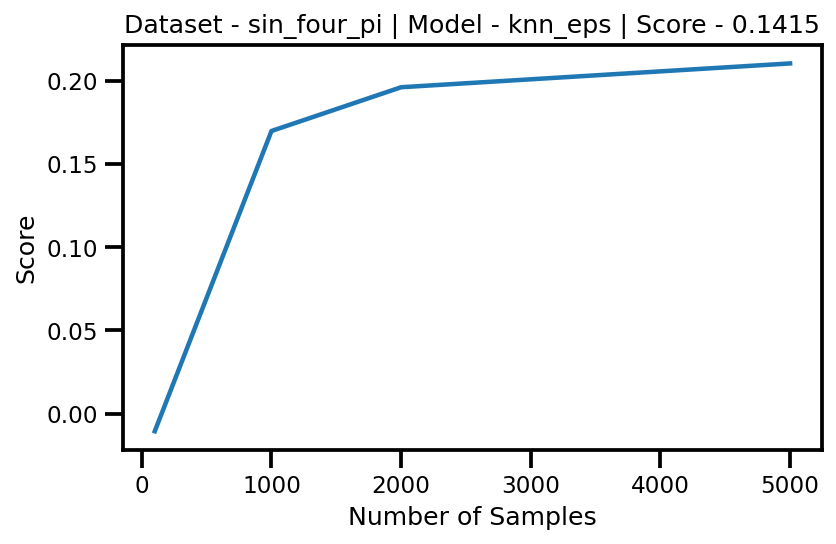

<Figure size 432x288 with 0 Axes>

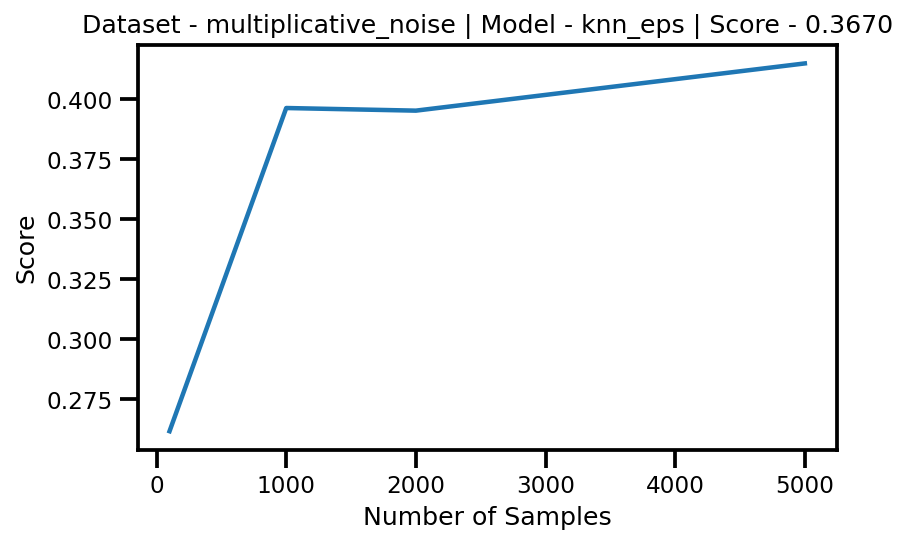

<Figure size 432x288 with 0 Axes>

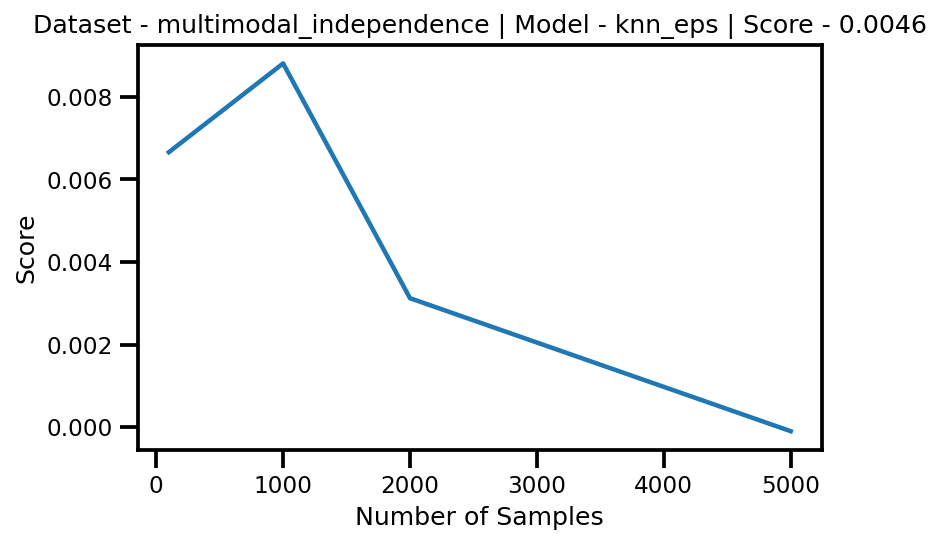

<Figure size 432x288 with 0 Axes>

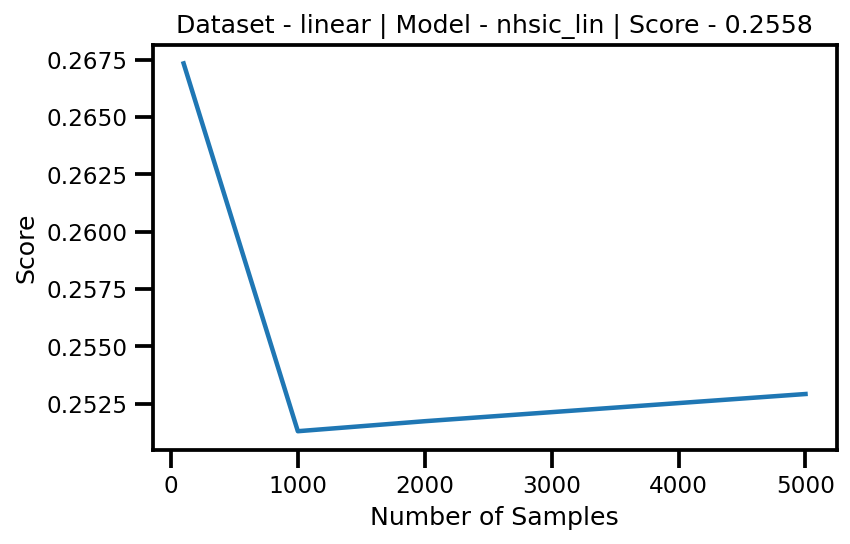

<Figure size 432x288 with 0 Axes>

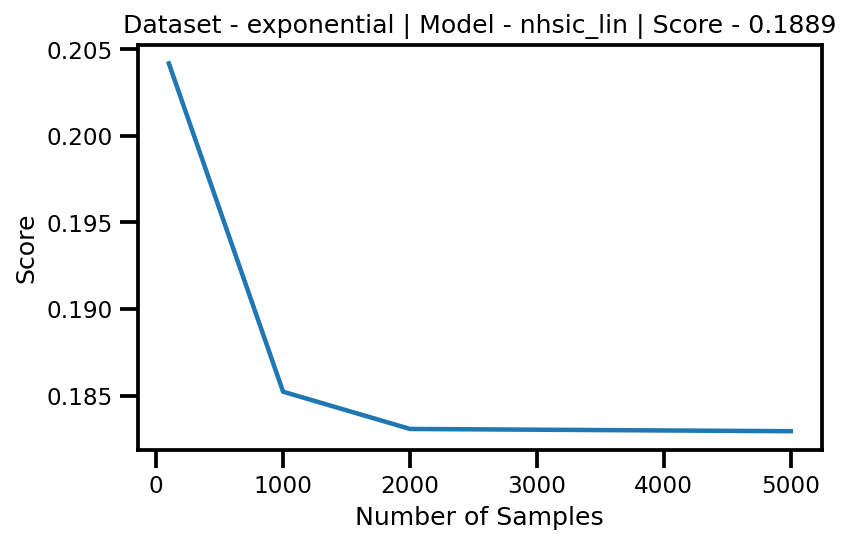

<Figure size 432x288 with 0 Axes>

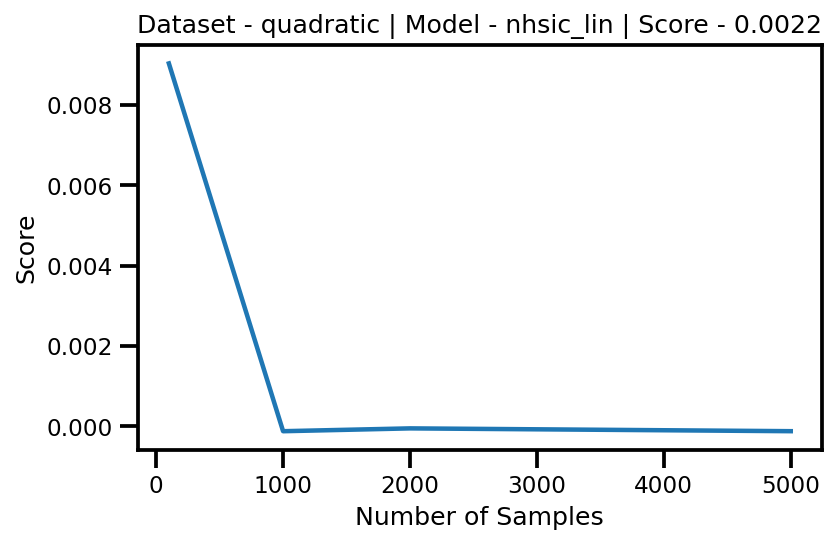

<Figure size 432x288 with 0 Axes>

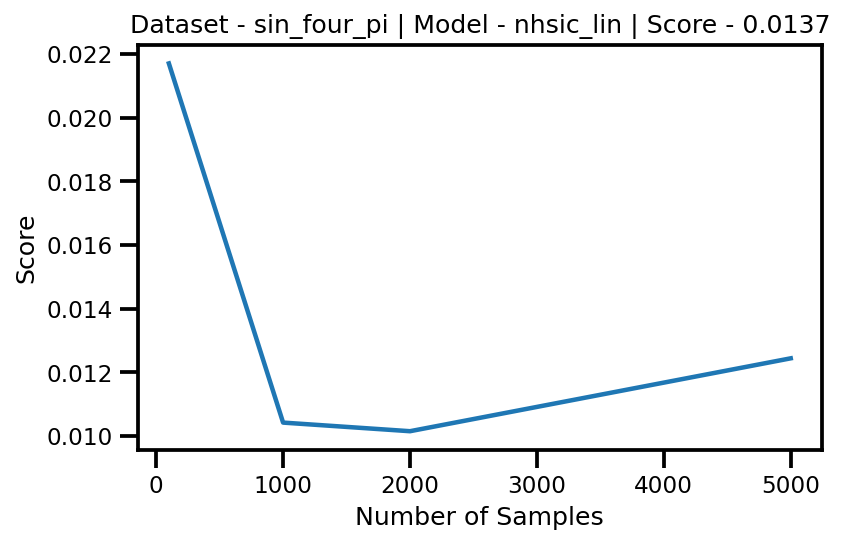

<Figure size 432x288 with 0 Axes>

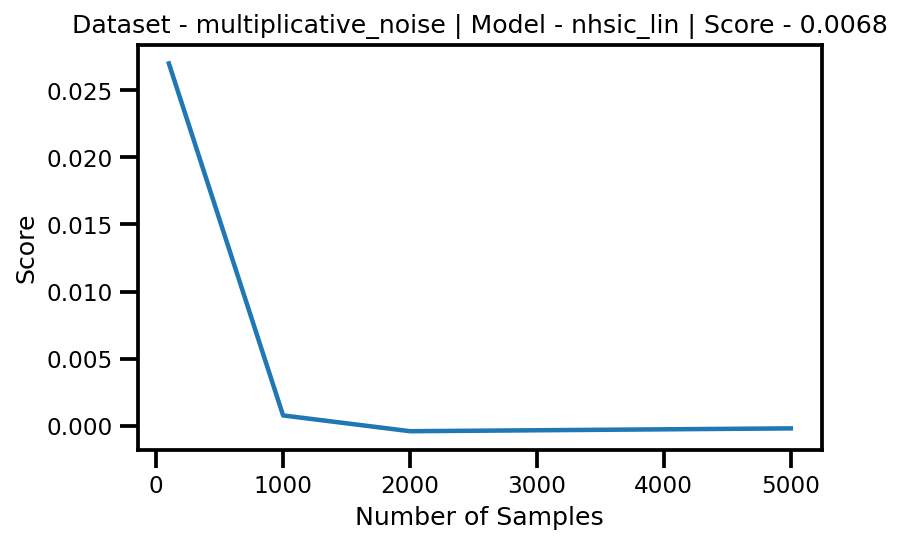

<Figure size 432x288 with 0 Axes>

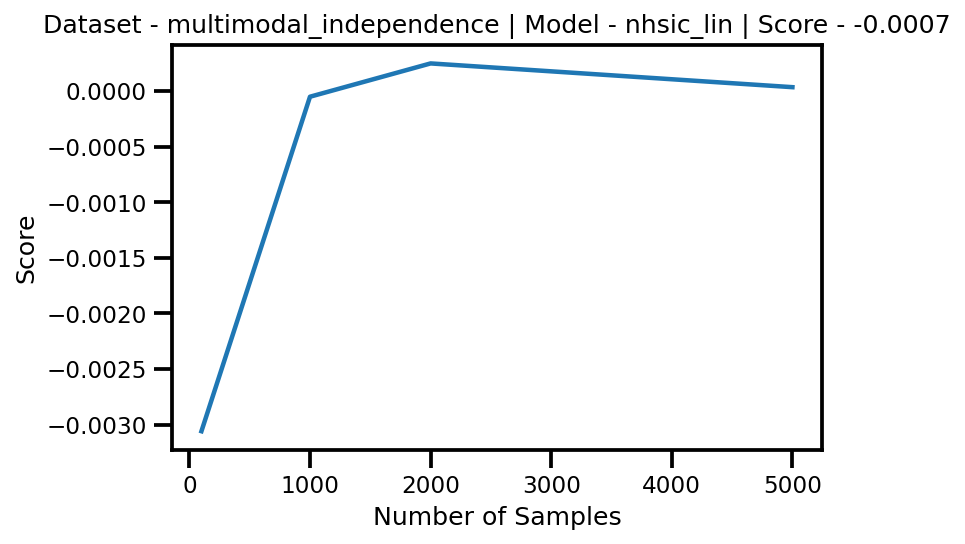

<Figure size 432x288 with 0 Axes>

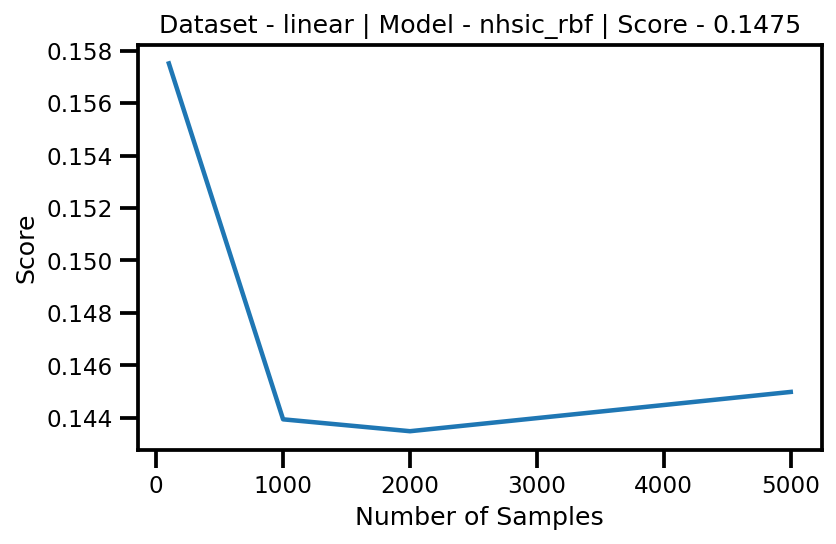

<Figure size 432x288 with 0 Axes>

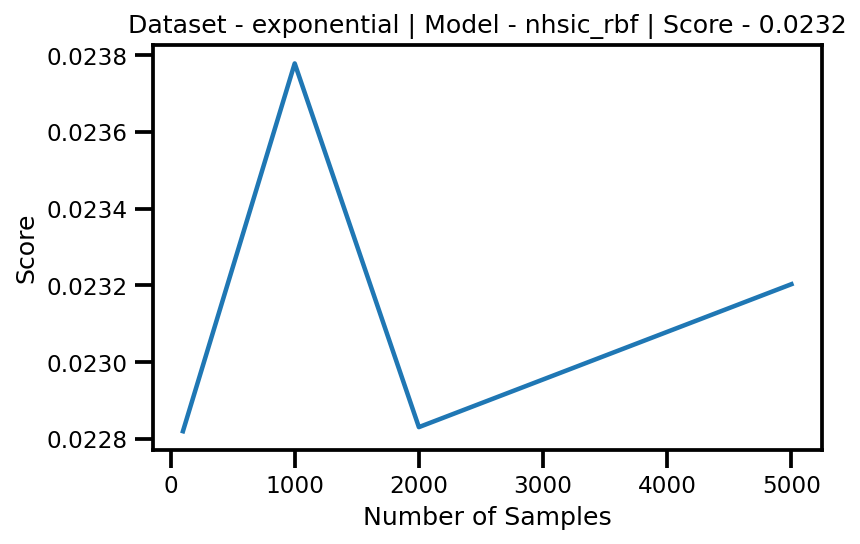

<Figure size 432x288 with 0 Axes>

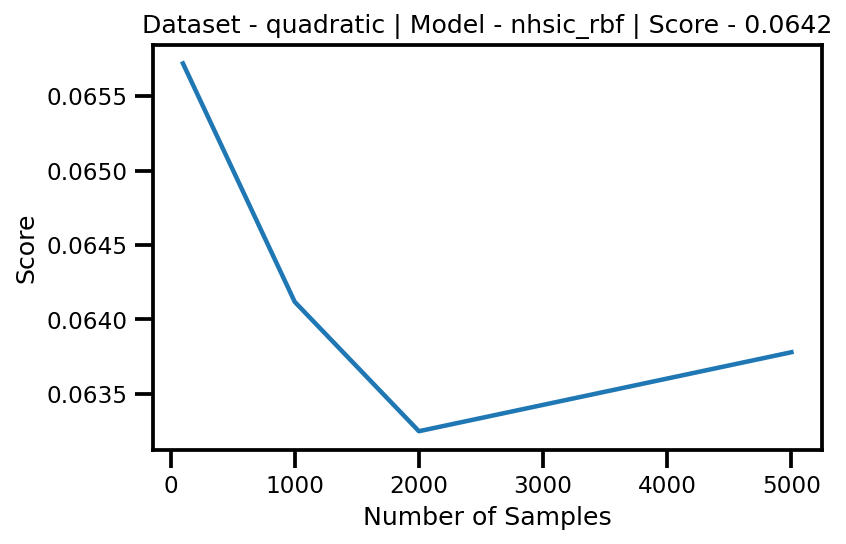

<Figure size 432x288 with 0 Axes>

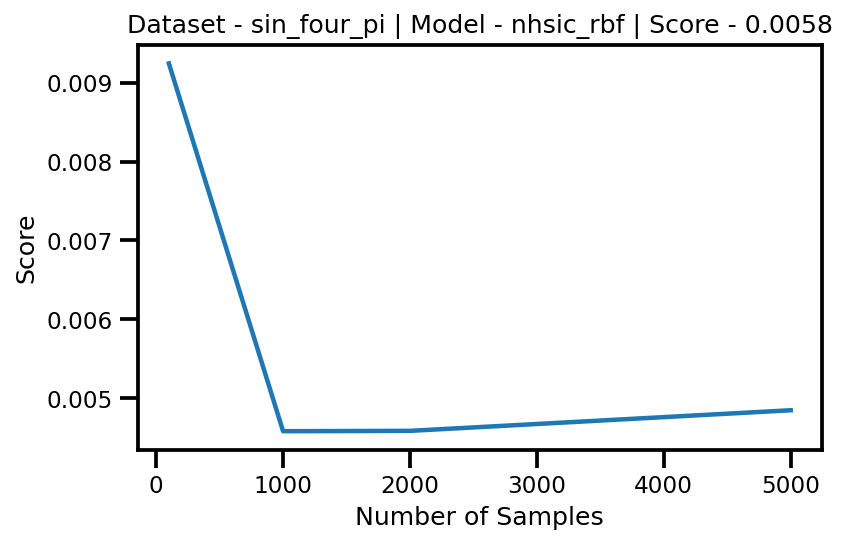

<Figure size 432x288 with 0 Axes>

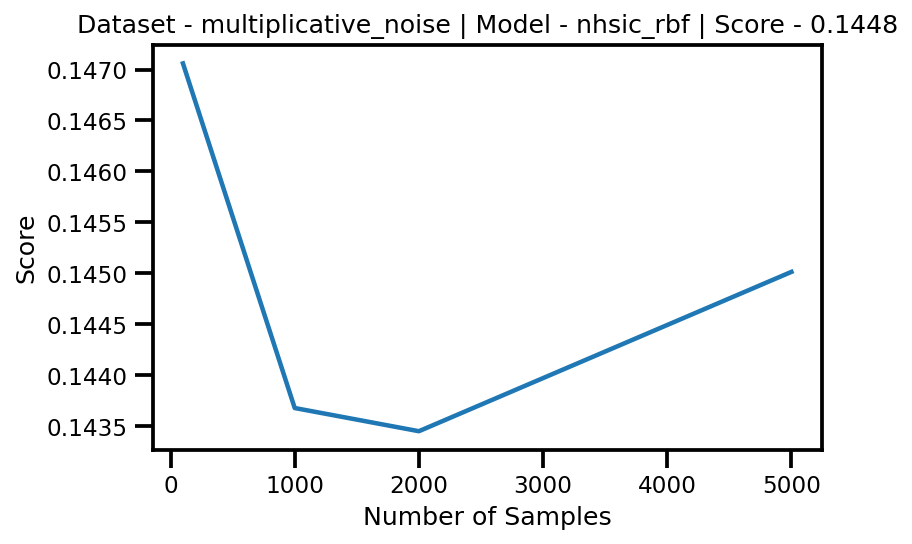

<Figure size 432x288 with 0 Axes>

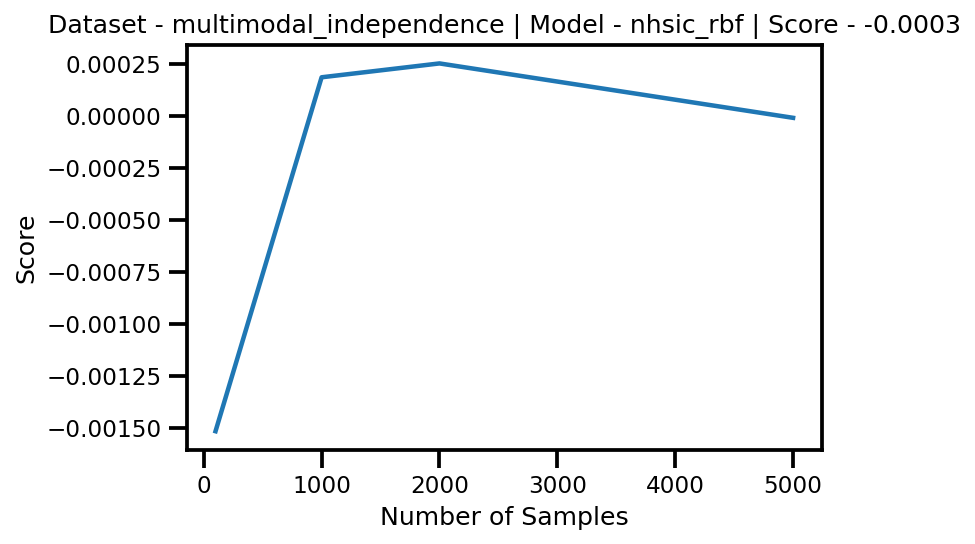

<Figure size 432x288 with 0 Axes>

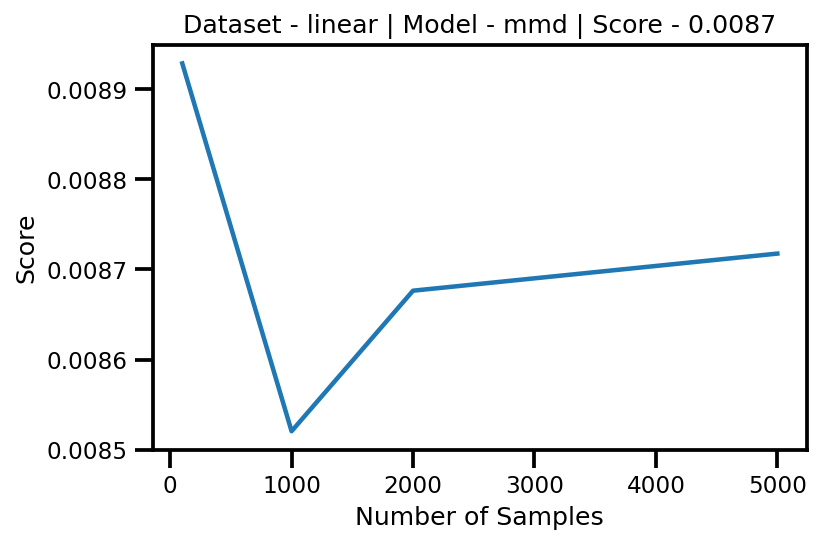

<Figure size 432x288 with 0 Axes>

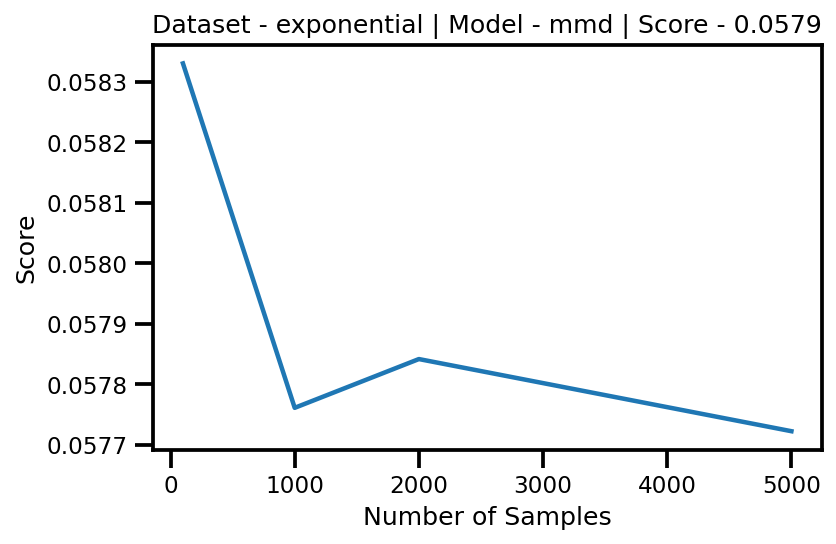

<Figure size 432x288 with 0 Axes>

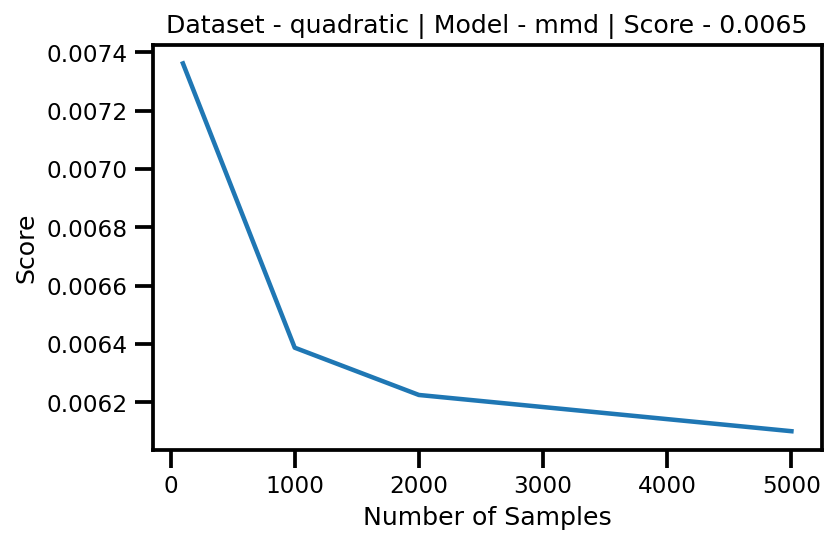

<Figure size 432x288 with 0 Axes>

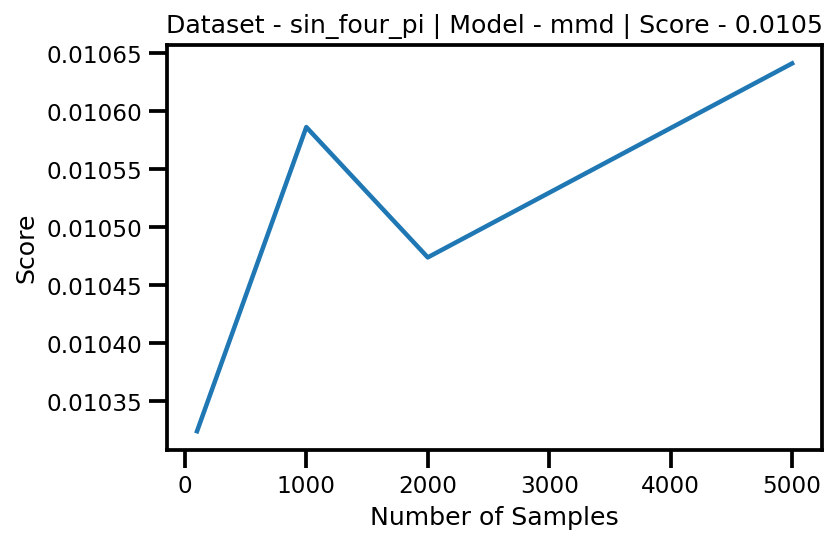

<Figure size 432x288 with 0 Axes>

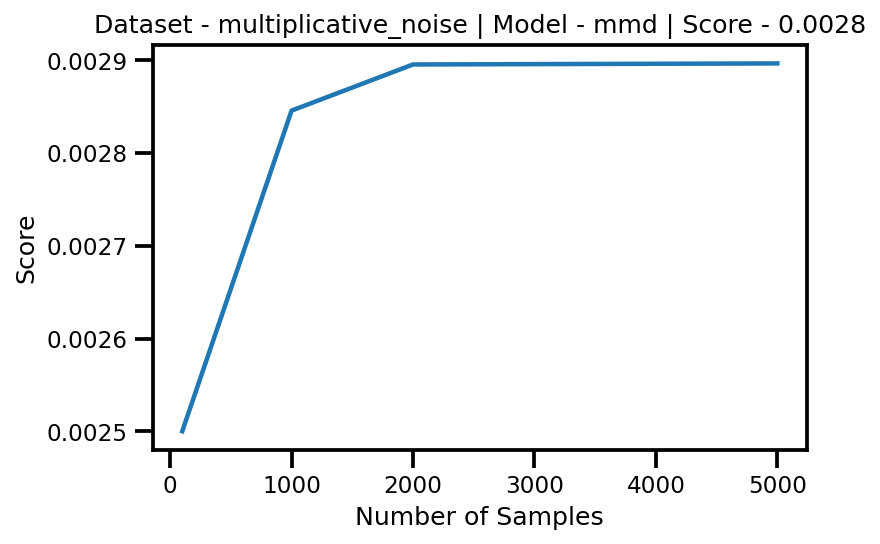

<Figure size 432x288 with 0 Axes>

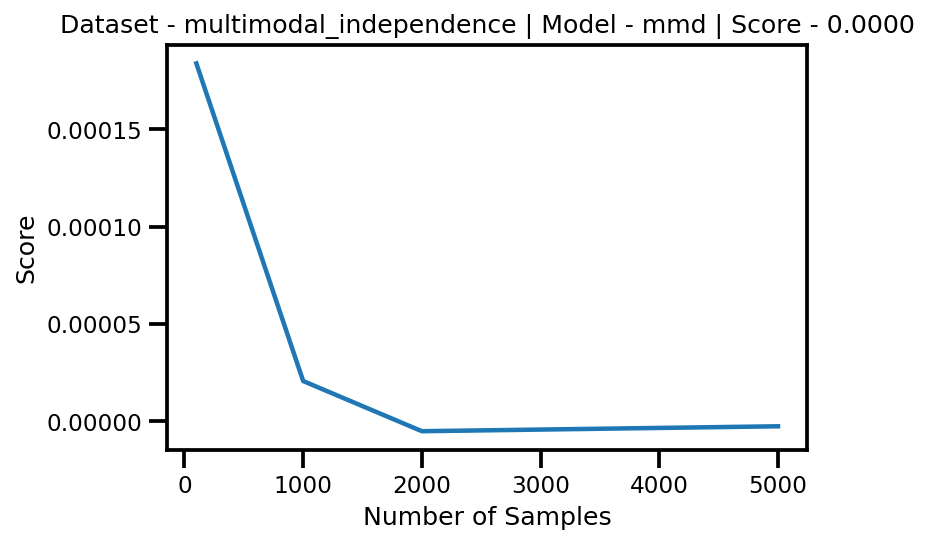

<Figure size 432x288 with 0 Axes>

In [171]:
models = ["gaussian", "rv", "knn_nbs", "knn_eps", "nhsic_lin", "nhsic_rbf", "mmd"]
datasets = [
    "linear",
    "exponential",
    "quadratic",
    "sin_four_pi",
    "multiplicative_noise",
    "multimodal_independence",
]

for imodel in models:
    for idataset in datasets:

        plot_results(results_xr, model=imodel, dataset=idataset)

#### k-NN Approximation

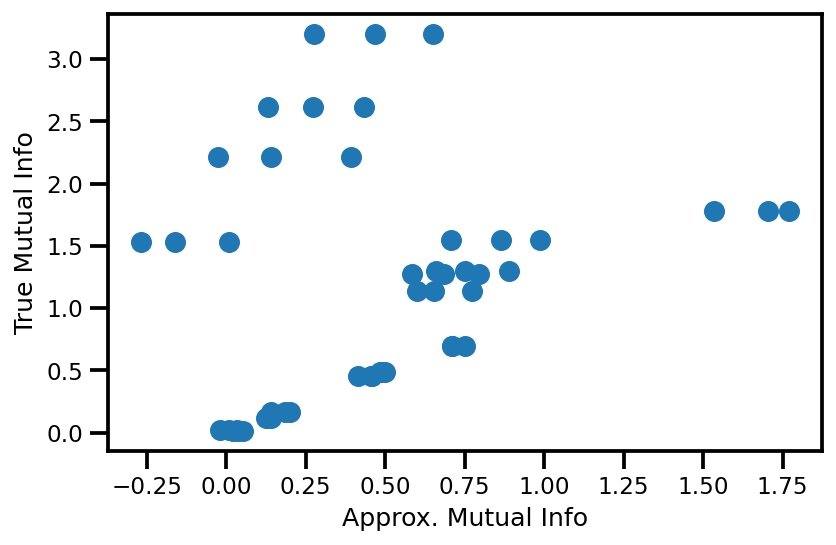

In [78]:
plot_results(results_df, "knn_nbs")

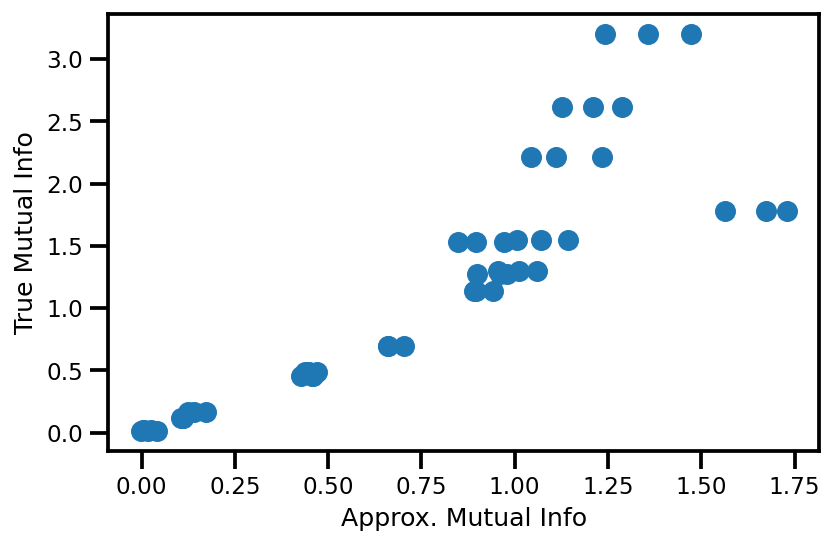

In [79]:
plot_results(results_df, "knn_eps")

#### RV Coefficient

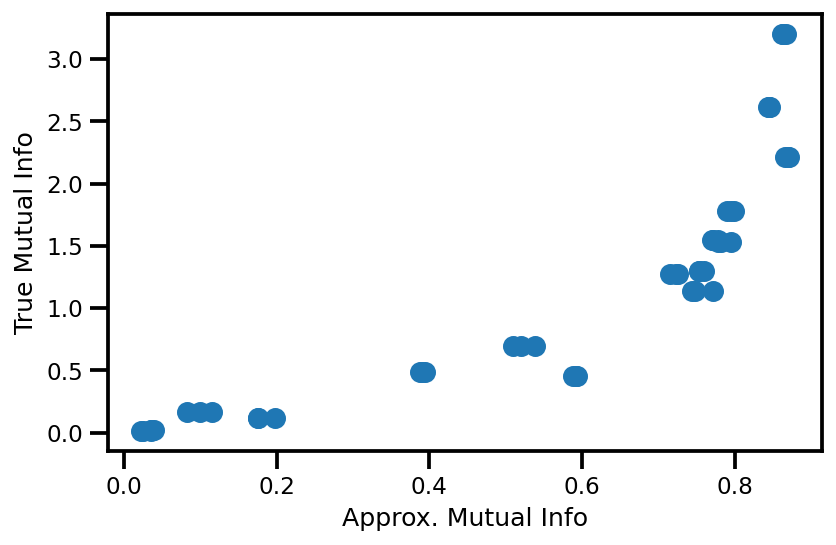

In [80]:
plot_results(results_df, "rv")

#### nHSIC (Linear)

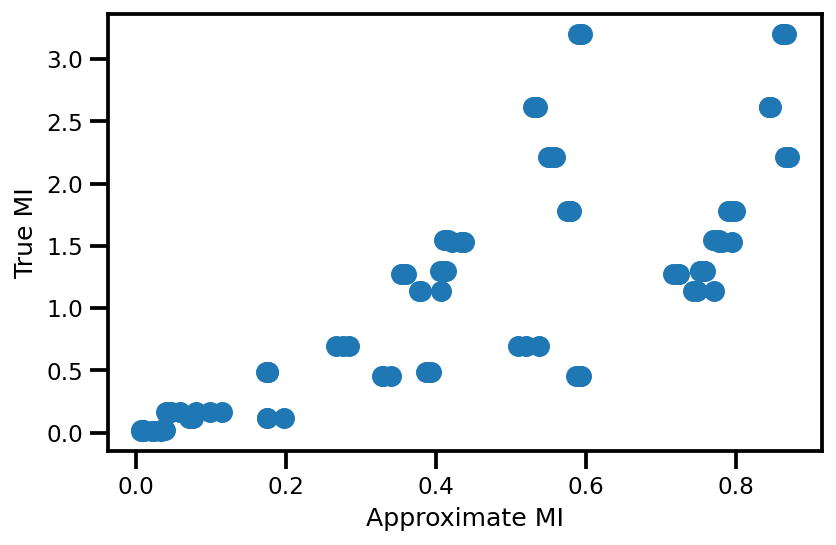

In [68]:
plot_results(results_df, "nhsic_lin")

#### nHSIC (RBF)

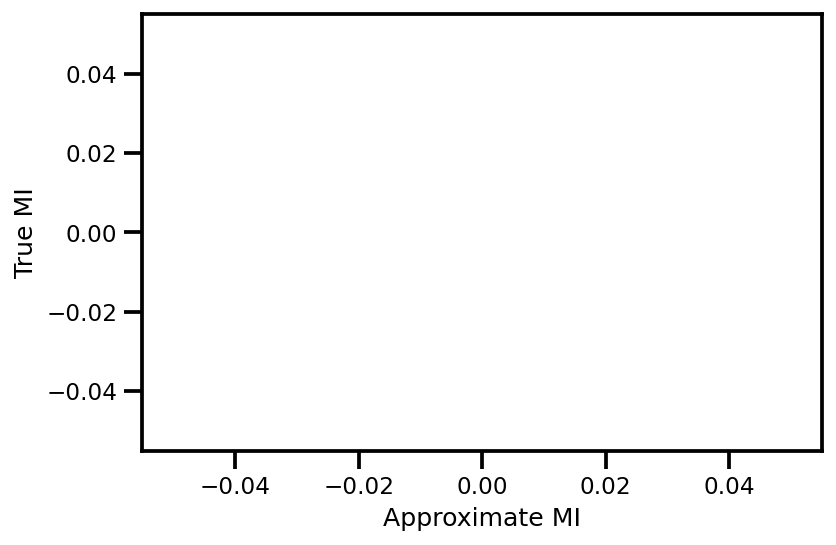

In [69]:
plot_results(results_df, "nhsic_rbf")

#### MMD (RBF)

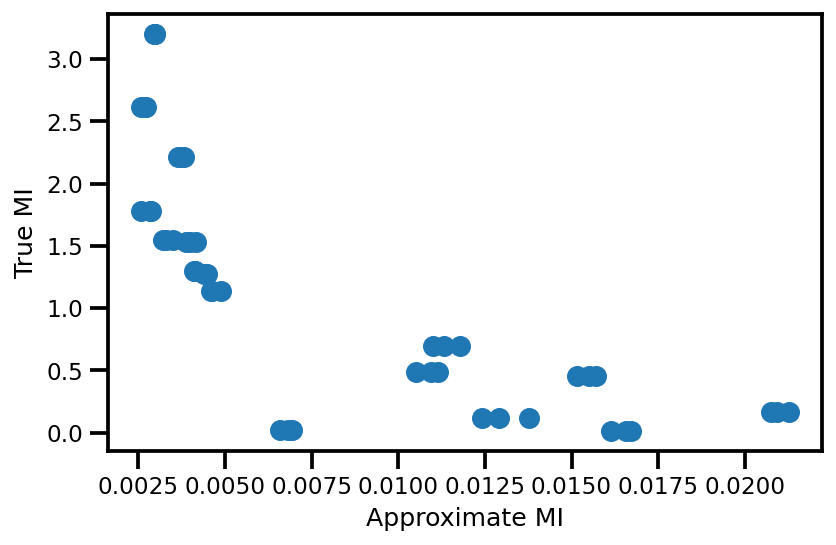

In [71]:
plot_results(results_df, "mmd")

### T-Student Dist.

#### Gaussian Approximation

In [80]:
from pysim.data.information.gaussian import generate_gaussian_mi_data

In [88]:
res_tuple = generate_gaussian_mi_data(n_samples=1_000, n_features=1)

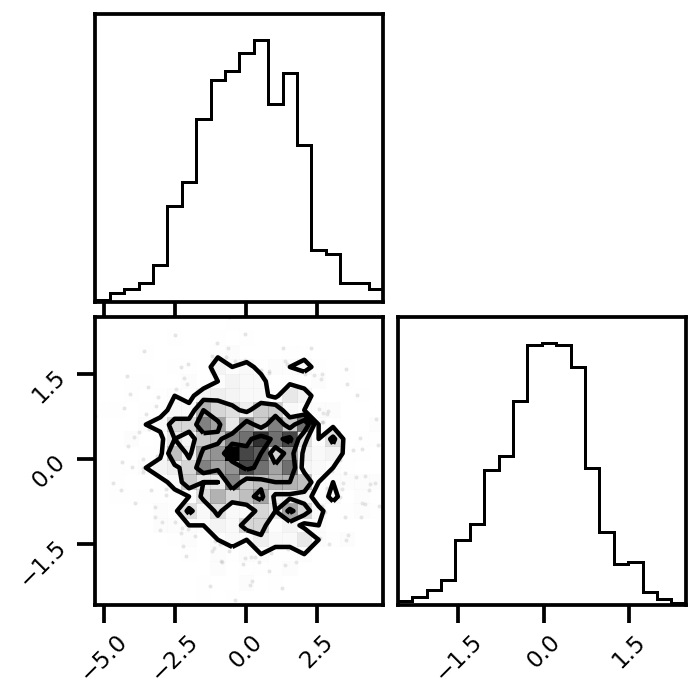

In [89]:
fig = corner.corner(np.concatenate([res_tuple.X, res_tuple.Y], axis=1), hist_factor=2)

#### kNN

#### 1 Feature

#### 2 Features

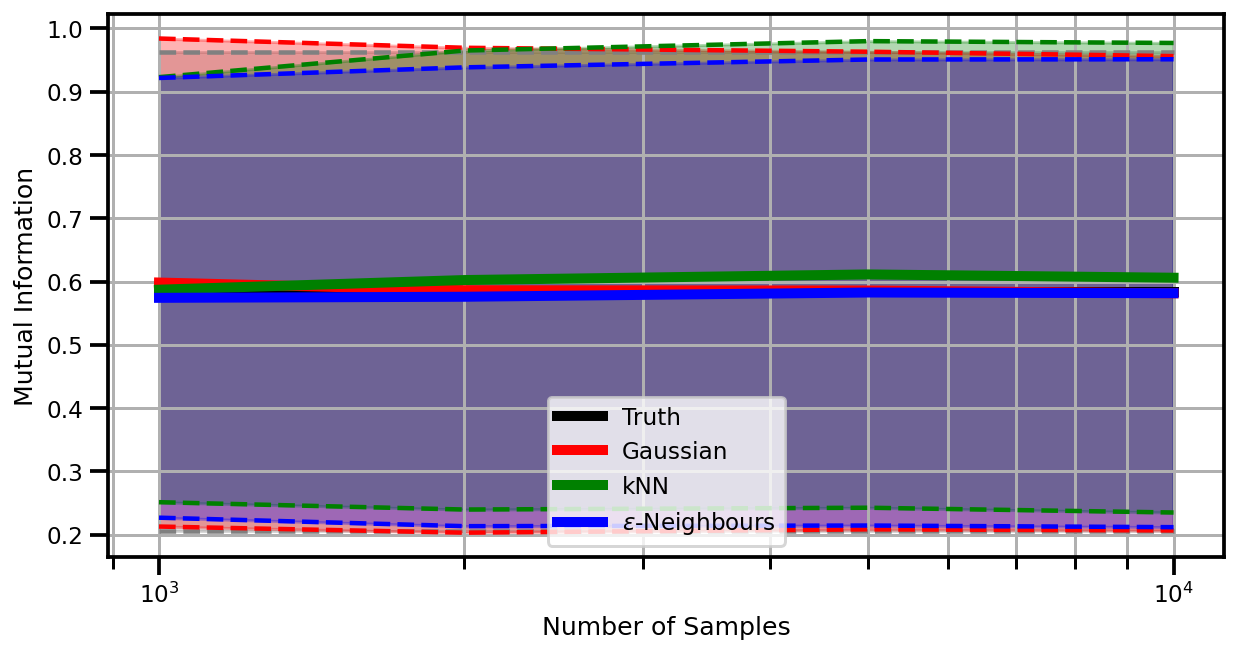

In [17]:
plot_results(results_xr, "gaussian", 2)

#### 5 Features

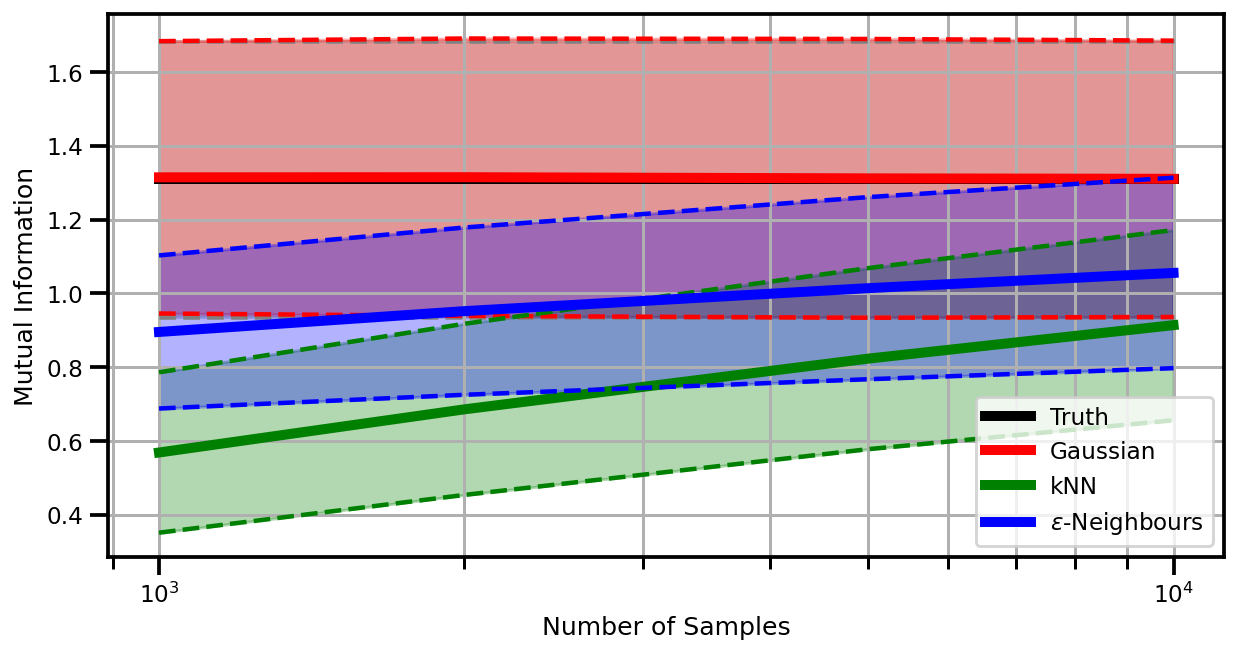

In [18]:
plot_results(results_xr, "gaussian", 5)

#### 10 Features

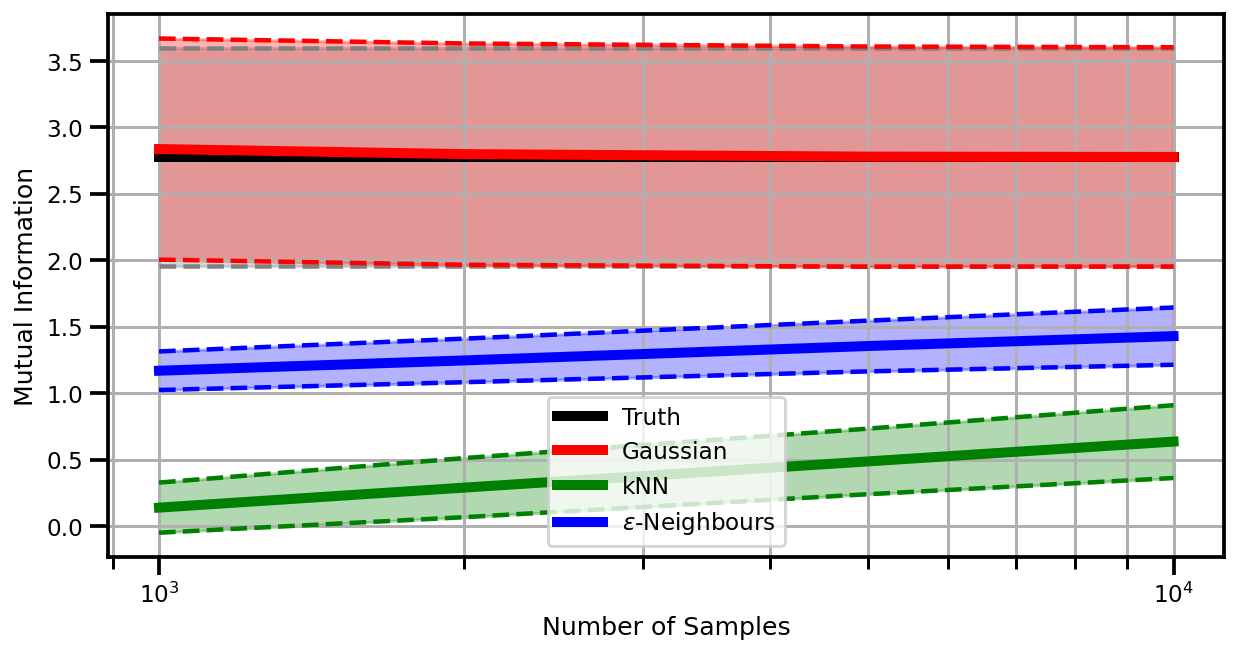

In [19]:
plot_results(results_xr, "gaussian", 10)

### Student T Distribution

#### 1 Features

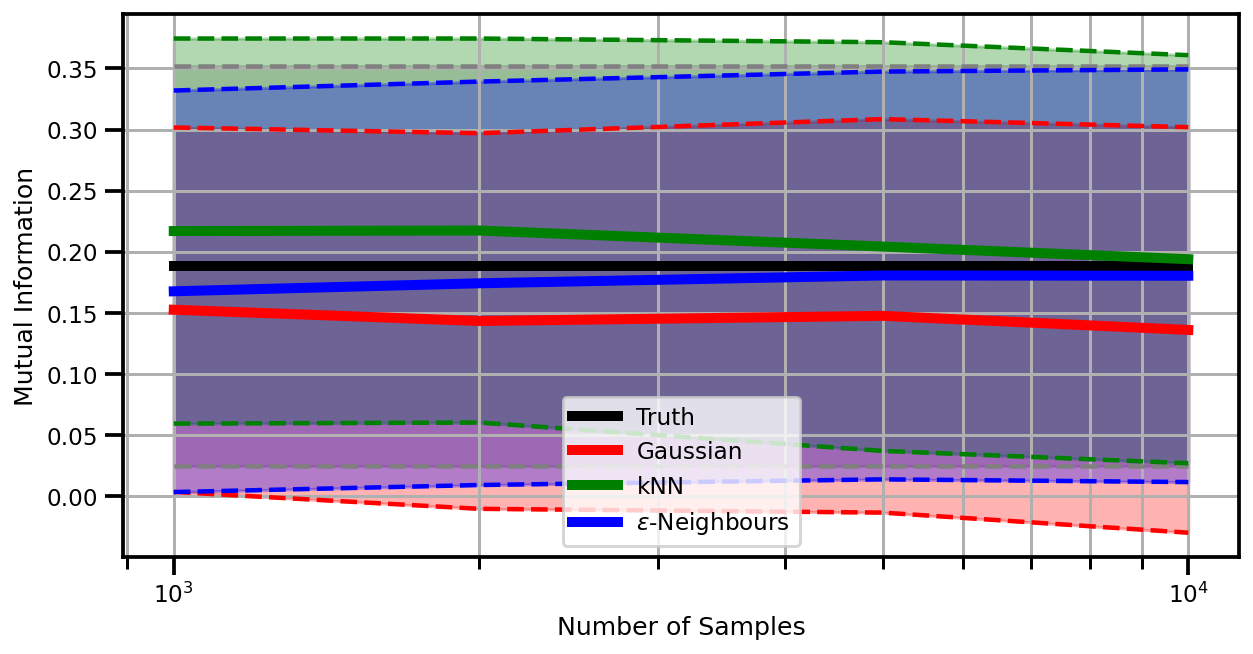

In [20]:
plot_results(results_xr, "studentt", 1)

#### 2 Features

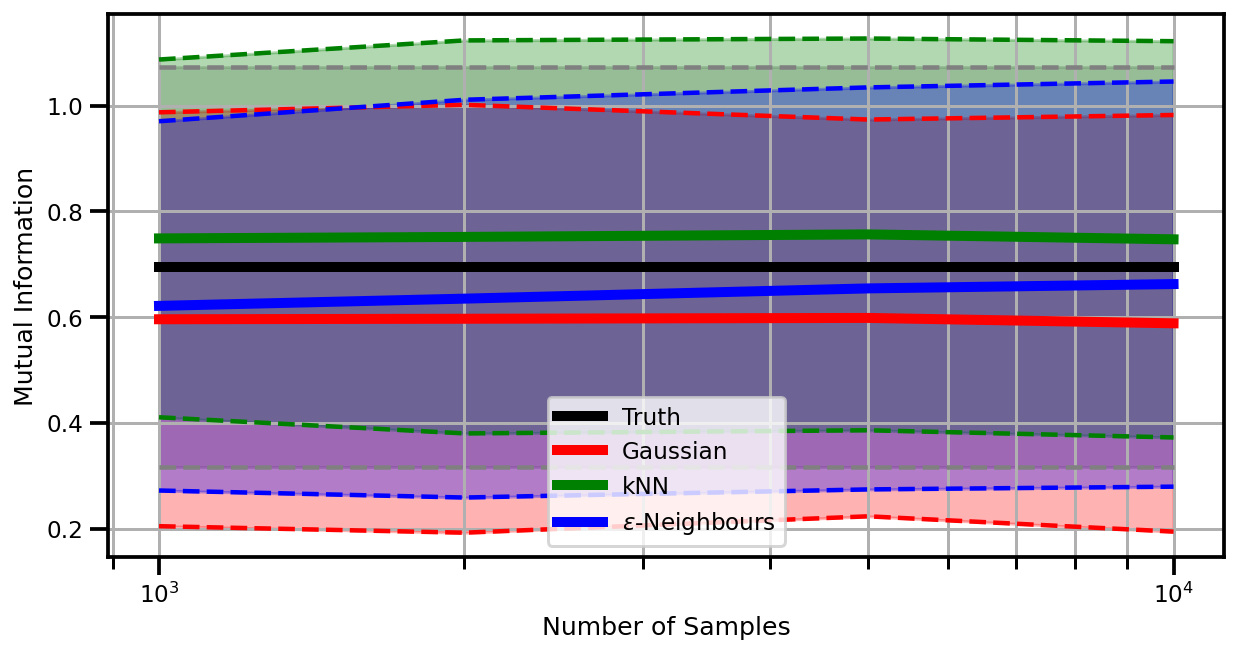

In [21]:
plot_results(results_xr, "studentt", 2)

#### 5 Features

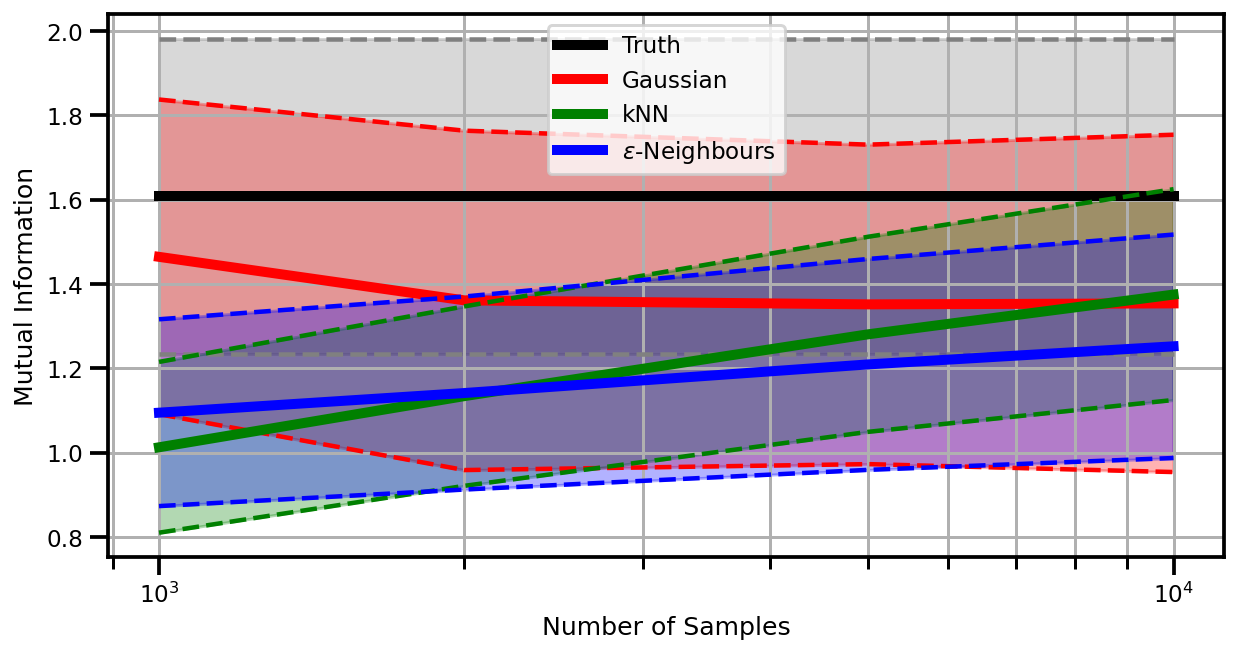

In [22]:
plot_results(results_xr, "studentt", 5)

#### 10 Features

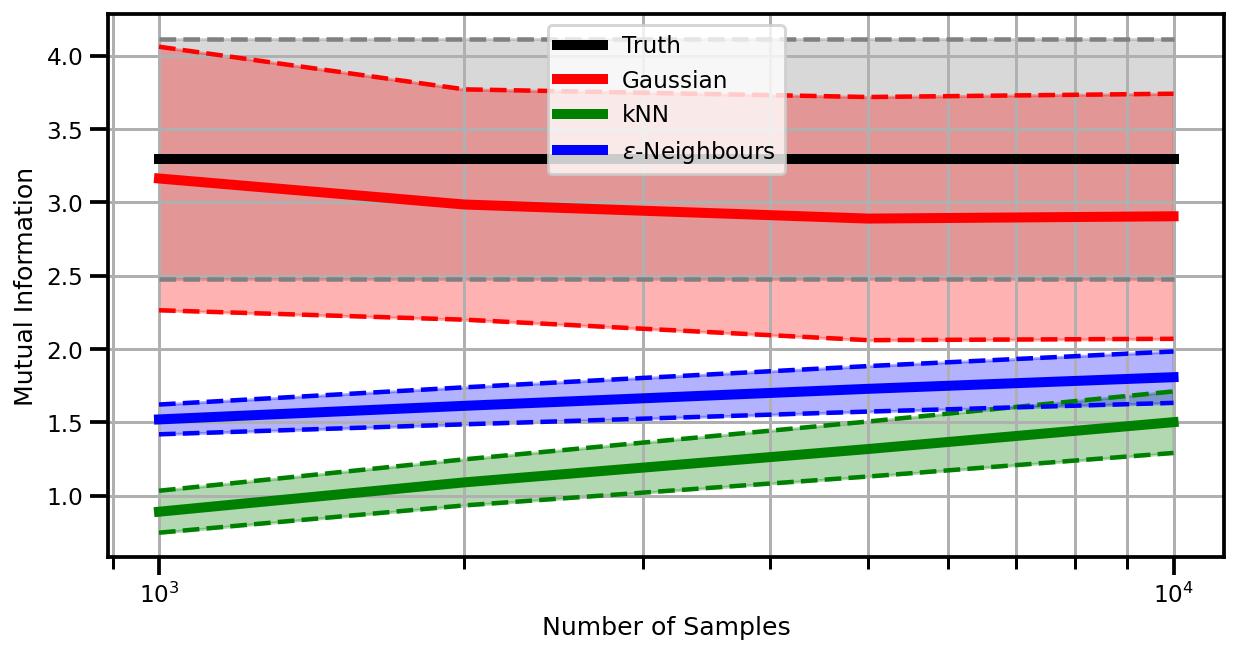

In [23]:
plot_results(results_xr, "studentt", 10)

### Cauchy

#### 1 Features

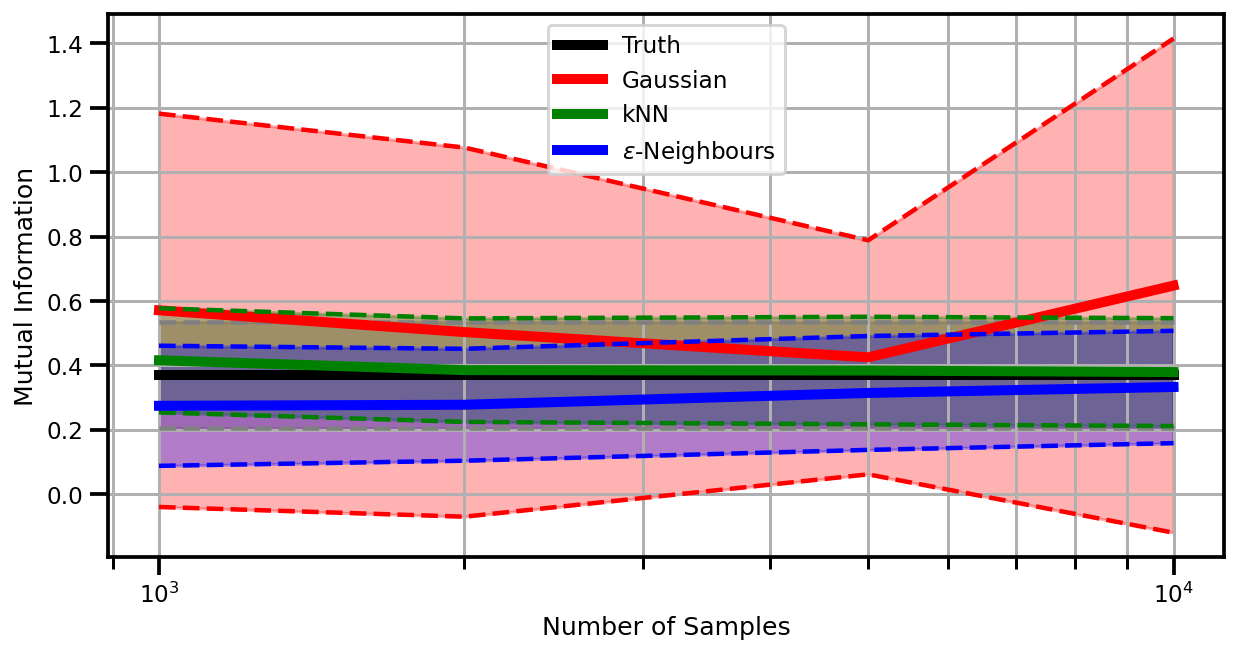

In [24]:
plot_results(results_xr, "cauchy", 1)

#### 2 Features

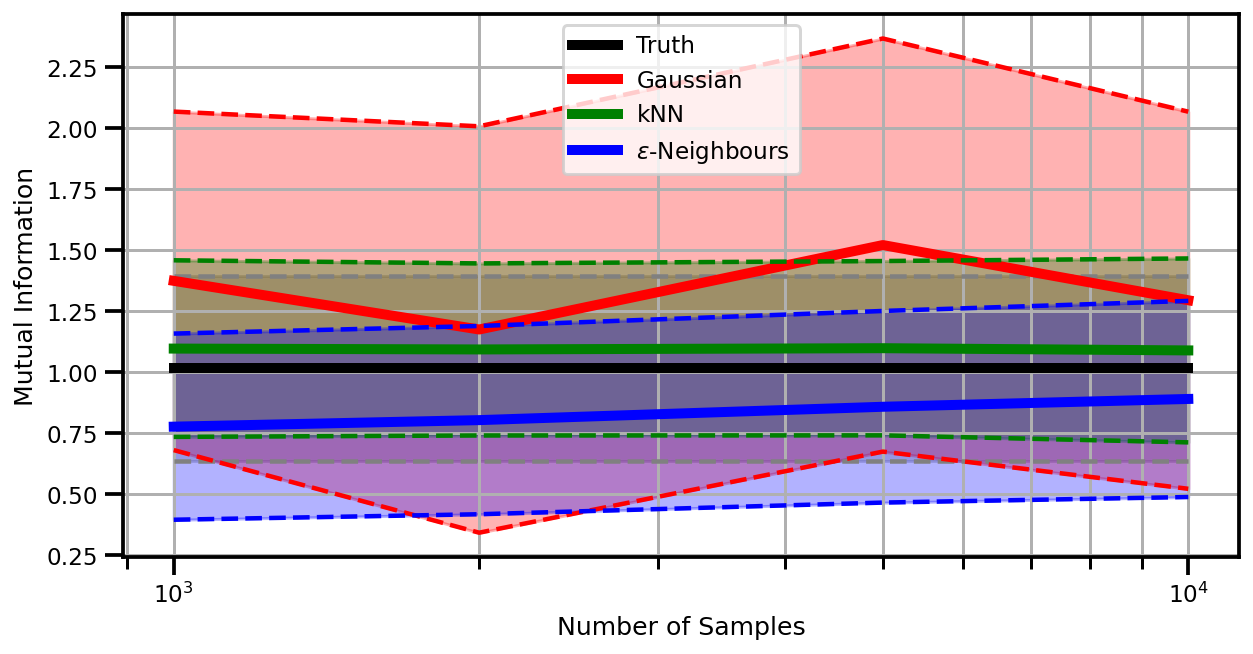

In [25]:
plot_results(results_xr, "cauchy", 2)

#### 5 Features

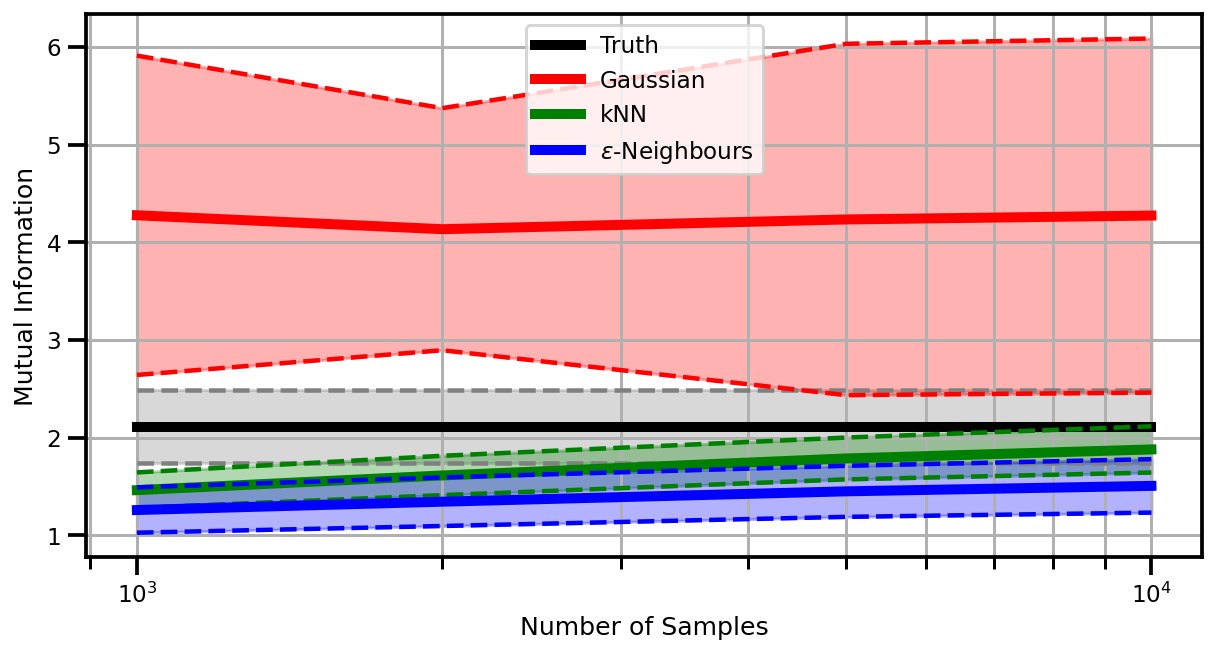

In [26]:
plot_results(results_xr, "cauchy", 5)

#### 10 Features

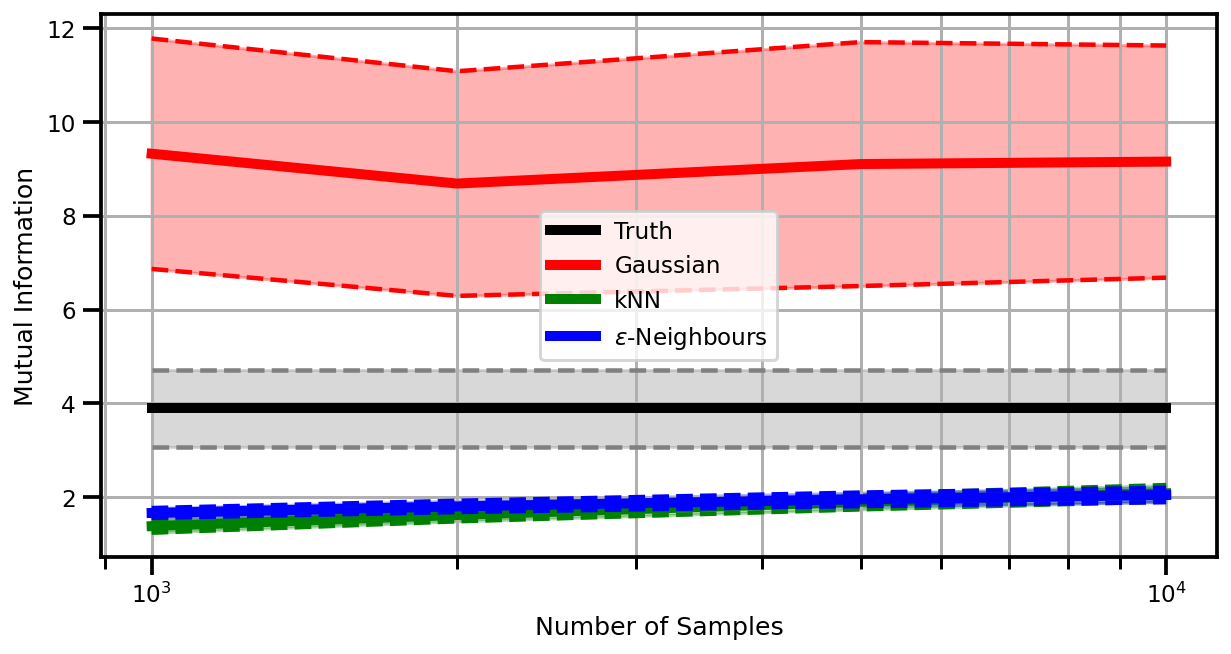

In [27]:
plot_results(results_xr, "cauchy", 10)